# Imports

In [ ]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pickle
from scipy.optimize import root

from potencial import get_expressions
plt.rcParams.update({
    # familia y fuentes
    'font.family':         'sans-serif',
    'font.sans-serif':     ['Lato'],
    'mathtext.fontset':    'custom',
    'mathtext.rm':         'Lato',
    'mathtext.it':         'Lato:italic',
    'mathtext.sf':         'Montserrat',
    # tamaños (los que acordamos)
    # 'axes.titlesize':      36,
    # 'axes.labelsize':      24,
    # 'xtick.labelsize':     20,
    # 'ytick.labelsize':     20,
    # 'legend.fontsize':     20,
    # pesos para dar “más cuerpo”
    'font.weight':         'bold',         # peso general
    'axes.titleweight':    'bold',           # peso del título del eje
    'axes.labelweight':    'bold',         # peso de las etiquetas de ejes
    # 'legend.title_fontsize':'24',            # tamaño opcional para título de leyenda
})

plot_dir = 'plots/simulations/'
import matplotlib as mpl
from matplotlib import font_manager
for f in font_manager.fontManager.ttflist:
    if 'Lato' in f.name:
        print(f.name, f.fname)

mpl.font_manager.fontManager.addfont(
    '/Users/javierrodriguezmartinez/Library/Fonts/Lato-Bold.ttf'
)

Lato /Users/javierrodriguezmartinez/Library/Application Support/Adobe/CoreSync/plugins/livetype/.r/.15709.otf


In [3]:
u_color = "#984ea3"
s_color = "#ff7f00"

In [ ]:
X1, X2, I_L, I_C, I_R = sp.symbols('X1 X2 I_L I_C I_R')
tau = 0.1
values = {
    "tau": tau,
    "c": 1,
    "g": 1,
    "s0": 1,
    "IL": 1/3,
    "IC": 1,
    "IR": 1,
    "I_I": 1/3,
    "sL": 0,
    "sC": 0,
    "sR": 0,
}

potencial, F1, F2, _ = get_expressions(values, type = "symbolic", substituted_I = True)
_ ,_ ,_ , H = get_expressions(values, type = "symbolic", substituted_I = False)
potencial_num, F1_num, F2_num, H_num = get_expressions(values, type = "numeric", substituted_I = False)

# Function Definitions

## Find Saddles


In [5]:
def find_crit_pts(IL, IC, IR, seeds=None, tol=1e-8):
    """
    Resuelve g1=g2=0 con scipy.optimize.root devolviendo siempre
    un np.array de floats y usando method='lm'.
    """
    if seeds is None:
        seeds = [(i, j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
    sols = set()
    
    def fun(vars):
        x, y = vars
        return np.array([
            F1_num(x, y, IL, IC, IR),
            F2_num(x, y, IL, IC, IR)
        ], dtype=float)
    
    for guess in seeds:
        sol = root(fun, guess, method='lm', tol=tol)
        if sol.success:
            x, y = sol.x
            sols.add((round(x,8), round(y,8)))
    return list(sols)


def compute_thresholds(IL, IC, IR):
    """
    Para una tripleta (IL, IC, IR), devuelve (th_r1, th_r2, th_r3),
    los mínimos umbrales positivos para r1=x+y, r2=-x+y, r3=-2y en los puntos silla.
    """
    cps = find_crit_pts(IL, IC, IR)
    
    saddle_pts = []
    for x, y in cps:
        evs = np.linalg.eigvals(H_num(x, y, IL, IC, IR))
        if evs[0] * evs[1] < 0:
            saddle_pts.append((x, y))
    
    r1s = [x + y    for x, y in saddle_pts if x + y    > 0]
    r2s = [-x + y   for x, y in saddle_pts if -x + y   > 0]
    r3s = [-2 * y   for x, y in saddle_pts if -2 * y   > 0]
    return (min(r1s) if r1s else None,
            min(r2s) if r2s else None,
            min(r3s) if r3s else None)

# === Ejemplo de uso ===
# IL_val, IC_val, IR_val son tus valores numéricos
IL_val, IC_val, IR_val = 1.0,1,1,
th1, th2, th3 = compute_thresholds(IL_val, IC_val, IR_val)
print(f"Thresholds: r1={th1:.4f}, r2={th2:.4f}, r3={th3:.4f}")

Thresholds: r1=1.1404, r2=1.1404, r3=1.0367


## Simulation Functions

In [ ]:
def U_t(t, onset=0.5, offset=1.5, duration=-1, amplitude=2):
    if duration <= 0:
        duration = offset - onset
    return np.where((t < onset) | (t > onset + duration), -1, -1 + amplitude * (t - onset) / duration)

def S_t(t, onset=0.30, offset=2, duration = -1 , amplitude=0.15):
    if duration < 0:
        duration = offset - onset
    return np.where(np.logical_or(t < onset, t > onset + duration), 0, amplitude)

def drift(X, I_L=IL_val, I_C=IC_val, I_R=IR_val):
    x, y = X
    return np.array([F1_num(x, y, I_L, I_C, I_R), F2_num(x, y, I_L, I_C, I_R)])

def simulate_path(x0, S_params, U_params, Tmax = 2, dt = tau/40, noise_amp = 1):
    N = int(Tmax / dt)
    X = np.empty((N+1, 2))
    X[0] = x0
    for i in range(N):
        x, y = X[i]
        dW = np.random.randn(3) * np.sqrt(dt)

        dB1 = (dW[0] - dW[1]) / 2
        dB2 = (dW[0] + dW[1] - 2*dW[2]) / 6
        U = U_t(i*dt, **U_params)
        S = S_t(i*dt, **S_params)
        
        # Euler–Maruyama
        X[i+1] = X[i] + drift(X[i], U+S, U, U) * dt + noise_amp * np.array([dB1, dB2])

        r1 = (X[i+1, 0] + X[i+1, 1])  # r₁
        r2 = -X[i+1, 0] + X[i+1, 1] # r₂
        r3 = -2*X[i+1, 1]  # r₃
    th1,th2,th3 = 0.5, 0.5, 0.5
    # th1, th2, th3 = compute_thresholds(U+S, U, U)ç
   
    if th1 is None:
        th1 = 0.5
    if th2 is None:
        th2 = 0.5
    if th3 is None:
        th3 = 0.5
    if   (r1>r2 and r1>r3 and r1>th1):
        winner = 'r1'
    elif (r2>r1 and r2>r3 and r2>th2):
        winner = 'r2'
    elif (r3>r1 and r3>r2 and r3>th3):
        winner = 'r3'
    else:
        winner = 'none'

    return X, winner           

def extract_r123(traj):
    X1_vals, X2_vals = traj[:, 0], traj[:, 1]
    r1_vals = (X1_vals + X2_vals)
    r2_vals = (-X1_vals + X2_vals)
    r3_vals = (-2 * X2_vals)
    return r1_vals, r2_vals, r3_vals
plt.figure(figsize=(8, 5))


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [68]:
def plot_rates(traj, S_params, U_params, crossing_U = True, Tmax = 2, dt = tau/40):
    t = np.linspace(0,(len(traj)+1) * dt, len(traj))
    t_vals = np.linspace(0, Tmax, len(traj))
    u_vals = U_t(t_vals, **U_params)
    stim_vals = S_t(t_vals, **S_params)

    r1, r2, r3 = extract_r123(traj)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(t, r1, color='red',   label=r'$r_L$')
    ax1.plot(t, r2, color='green', label=r'$r_C$')
    ax1.plot(t, r3, color='blue',  label=r'$r_R$')
    ax1.axhline(0.5, color='k', linestyle='-.',
                linewidth=1, label='Umbral: 0.5')
    # ax1.set_ylim(-2, 3)
    ax1.set_ylabel('Rates $r_i$')
    ax1.set_title('Evolution of $r_L$, $r_C$, $r_R$')
    ax1.legend(loc='upper right')

    ax2.plot(t_vals, u_vals,   linestyle='-', label=r'$U(t)$', color = u_color, alpha=1)
    ax2.plot(t_vals, stim_vals,linestyle='-', label=r'$S(t)$',color = s_color, alpha=1)
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Amplitud')
    ax2.set_title('Inputs $U(t)$ and $S(t)$')
    ax2.legend(loc='upper right')

    onset     = U_params.get('onset', 0.5)
    duration    = U_params.get('duration', -1)
    offset    = U_params.get('offset', 1.5)
    amplitude = U_params.get('amplitude', 2)
    if duration < 0:
        duration = offset - onset
    t_line = onset + duration / amplitude

    if crossing_U:
        ax2.axvline(t_line, color='k', linestyle='--',
                linewidth=1, label=r'$U(t)=1$')

    plt.tight_layout()
    plt.show()


In [39]:
V_num = potencial_num

theta     = 0.5         # umbral sobre r_i
noise_amp = 0.5        # intensidad del ruido
dt        = 1e-3        # paso de tiempo
dt = tau / 40
Tmax      = 2       # tiempo máximo de simulación
n_trajs   = 1000       # número de trayectorias Monte Carlo
x0        = np.array([0,0])  # condición inicial de ejemplo
r0 = np.array([0,0,0])  # posición inicial de la partícula
x0 = np.array([(r0[0]+r0[1])/2, (r0[0]-r0[1])/2])  # condición inicial en el espacio de fase


wins = {'r1': 0, 'r2': 0, 'r3': 0, 'none': 0}
all_paths = []

for _ in range(n_trajs):
    traj, win_type = simulate_path(x0, noise_amp=1)
    all_paths.append(traj)
    if win_type == 'r3':
        wins['r3'] += 1
    elif win_type == 'r1':
        wins['r1'] += 1
    elif win_type == 'r2':
        wins['r2'] += 1
    else:
        wins['none'] += 1


p_r1 = wins['r1'] / n_trajs
p_r2 = wins['r2'] / n_trajs
p_r3 = wins['r3'] / n_trajs
p_none = wins['none'] / n_trajs

print(f"P(r₁ gana) = {p_r1:.3f}")
print(f"P(r₂ gana) = {p_r2:.3f}")
print(f"P(r₃ gana) = {p_r3:.3f}")
print(f"P(no hay ganador) = {p_none:.3f}")

xs = np.linspace(-7, 7, 200)
ys = np.linspace(-5, 4, 200)
Xg, Yg = np.meshgrid(xs, ys)
Vg = V_num(Xg, Yg, 1,1,1)
Vg = np.clip(Vg, -100, 50)

plt.figure(figsize=(6, 5))

plt.contour(Xg, Yg, Vg, levels=30)
r1_vals = Xg + Yg
r2_vals = -Xg + Yg
r3_vals = -2 * Yg

plt.contour(Xg, Yg, Vg, levels=30)

# for U_s in saddle_us:
#     plt.contour(
#         Xg, Yg, Vg,
#         levels=[U_s],
#         colors='red',
#         linestyles='--',
#         linewidths=1.2
#     )

for traj in all_paths[:1]:
    plt.plot(traj[:,0], traj[:,1], lw=0.8)
plt.axhline(0, color='k', lw=0.5)
plt.xlabel('X₁ = r₁ + r₂')
plt.ylabel('X₂ = r₁ + r₂ - 2r₃')
plt.title('Trayectorias sobre el potencial')
plt.show()


for traj in all_paths[:1]:
    r1, r2, r3 = extract_r123(traj)
    t = np.linspace(0, len(traj) * dt, len(traj))
    plt.plot(t, r1, color='red', alpha=1, label=f'$r_L$')
    plt.plot(t, r2, color='green', alpha=1, label='$r_C$')
    plt.plot(t, r3, color='blue', alpha=1, label='$r_R$')

t_vals = np.linspace(0, Tmax, len(traj))
u_vals = U_t(t_vals)
stim_vals = S_t(t_vals)
plt.plot(t_vals, u_vals, color='purple', linestyle='--', label='$U_t$')
plt.plot(t_vals, stim_vals, color='orange', linestyle='--', label='$S_t$')


# positive_thresholds = [r for r in saddle_r1s if r > 0]
# if positive_thresholds:
#     lowest_th = min(positive_thresholds)
#     plt.axhline(
#         lowest_th,
#         color='k',
#         linestyle='-.',
#         linewidth=1,
#         label=f'Rate to reach the basins of attraction: {lowest_th:.3f}'
#     )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=8)

plt.xlabel("Time s")
plt.ylabel("rᵢ")
plt.title("Evolution of $r_L$, $r_C$, $r_R$, $U_t$, and $S_t$")
plt.tight_layout()
plt.show()

TypeError: simulate_path() missing 2 required positional arguments: 'S_params' and 'U_params'

Simulating trajectories: 100%|██████████| 1000/1000 [00:12<00:00, 78.24it/s]


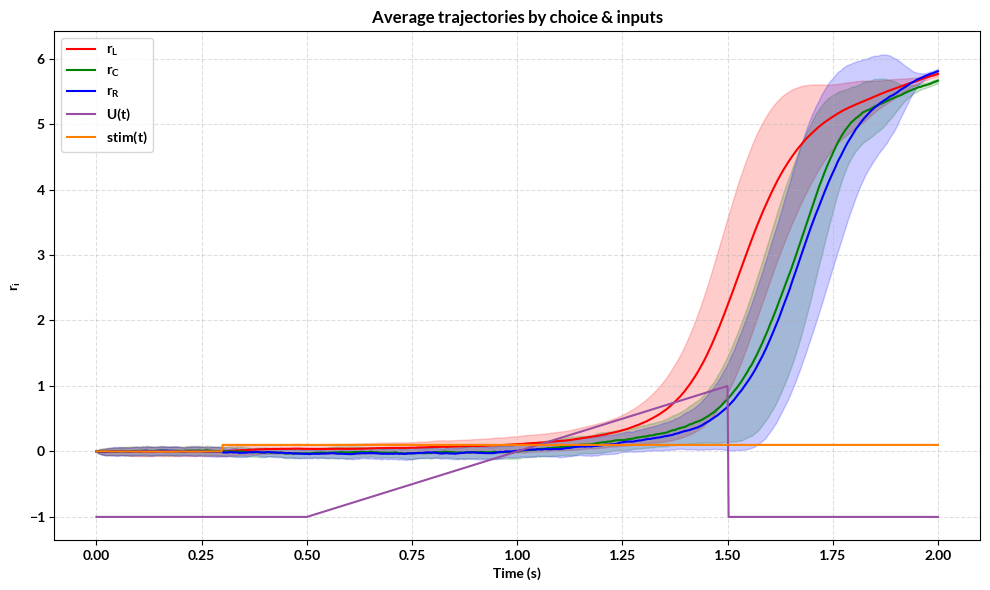

In [41]:
# 1) Simular y agrupar trials
r1_trials = []
r2_trials = []
r3_trials = []
n_trajs = 1000

for _ in tqdm(range(n_trajs), desc="Simulating trajectories"):
    traj, win_type = simulate_path(x0,S_params_def, U_params_def, noise_amp=0.5)
    r1, r2, r3 = extract_r123(traj)
    if win_type == 'r1':
        r1_trials.append(r1)
    elif win_type == 'r2':
        r2_trials.append(r2)
    elif win_type == 'r3':
        r3_trials.append(r3)
    # los trials sin umbral los ignoramos

min_len = min(len(r) for groupe in (r1_trials, r2_trials, r3_trials) for r in groupe)
t = np.linspace(0, dt*(min_len-1), min_len)

def plot_avg(trials, label, color):
    arr = np.array([r[:min_len] for r in trials])
    mean = arr.mean(axis=0)
    std  = arr.std(axis=0)
    plt.plot(t, mean, label=label, color=color, lw=1.5)
    plt.fill_between(t, mean-std, mean+std, color=color, alpha=0.2)

plt.figure(figsize=(10, 6))
if r1_trials:
    plot_avg(r1_trials, '$r_L$', 'red')
if r2_trials:
    plot_avg(r2_trials, '$r_C$', 'green')
if r3_trials:
    plot_avg(r3_trials, '$r_R$', 'blue')

U_vals   = U_t(t)
stim_vals= S_t(t)
plt.plot(t, U_vals,   color = u_color ,linestyle = '-', label='$U(t)$',   lw=1.5)
plt.plot(t, stim_vals, color = s_color, linestyle='-', label='$\\mathrm{stim}(t)$', lw=1.5)

plt.xlabel('Time (s)')
plt.ylabel('$r_i$')
plt.title('Average trajectories by choice & inputs')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


Simulando trayectorias: 100%|██████████| 1000/1000 [00:12<00:00, 78.82it/s]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/642066119.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(t_full, U_t(t_full),    'k--',    label='$U(t)$', color = u_color,   lw=1.5)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/642066119.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "orange" (-> color=(1.0, 0.6470588235294118, 0.0, 1.0)). The keyword argument will take precedence.
  ax2.plot(t_full, S_t(t_full), 'orange', linestyle='--', color = s_color, label='$\\mathrm{stim}(t)$', lw=1.5)


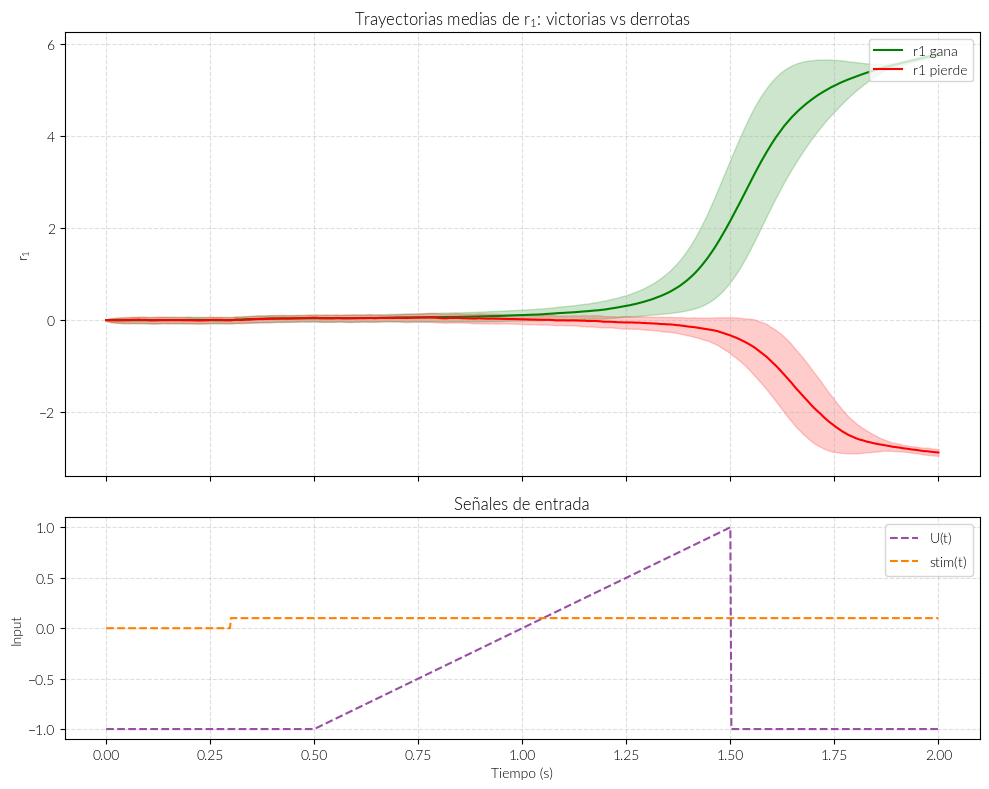

In [ ]:
n_trajs = 1000
r1_win_trials = []
r1_loss_trials = []

for _ in tqdm(range(n_trajs), desc="Simulando trayectorias"):
    traj, win_type = simulate_path(x0, S_params_def, U_params_def, noise_amp=0.5)
    r1, _, _ = extract_r123(traj)
    if win_type == 'r1':
        r1_win_trials.append(r1)
    elif win_type in ('r2', 'r3'):
        r1_loss_trials.append(r1)

# Calcula media y std sin recortar al mismo largo
def compute_mean_std(trials):
    max_len = max(len(r) for r in trials)
    mean = np.zeros(max_len)
    std  = np.zeros(max_len)
    for i in range(max_len):
        vals = [r[i] for r in trials if len(r) > i]
        mean[i] = np.mean(vals)
        std[i]  = np.std(vals)
    t = np.arange(max_len) * dt
    return t, mean, std

t_win,  mean_win,  std_win  = compute_mean_std(r1_win_trials)
t_loss, mean_loss, std_loss = compute_mean_std(r1_loss_trials)

# Prepara subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                               gridspec_kw={'height_ratios': [2, 1]})

# --- Primer plot: r1 wins vs losses ---
ax1.plot(t_win, mean_win,      label='r1 gana',  color='green', lw=1.5)
ax1.fill_between(t_win,
                 mean_win-std_win,
                 mean_win+std_win,
                 color='green', alpha=0.2)

ax1.plot(t_loss, mean_loss,      label='r1 pierde',  color='red', lw=1.5)
ax1.fill_between(t_loss,
                 mean_loss-std_loss,
                 mean_loss+std_loss,
                 color='red', alpha=0.2)

ax1.set_ylabel('$r_1$')
ax1.set_title('Trayectorias medias de $r_1$: victorias vs derrotas')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(loc='upper right')

t_max = max(t_win.max(), t_loss.max())
t_full = np.linspace(0, t_max, int(t_max/dt) + 1)

ax2.plot(t_full, U_t(t_full),    'k--',    label='$U(t)$', color = u_color,   lw=1.5)
ax2.plot(t_full, S_t(t_full), 'orange', linestyle='--', color = s_color, label='$\\mathrm{stim}(t)$', lw=1.5)

ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Input')
ax2.set_title('Señales de entrada')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
r1_win, r1_loss, other_win, other_loss = [], [], [], []
n_trajs = 10000

for _ in tqdm(range(n_trajs), desc="Simulando"):
    traj, win = simulate_path(x0, noise_amp=0.5)
    r1, r2, r3 = extract_r123(traj)
    if win == 'r1':
        r1_win.append(r1)
        other_loss += [r2, r3]
    elif win == 'r2':
        other_win.append(r2)
        r1_loss.append(r1)
        other_loss.append(r3)
    else:  # win == 'r3'
        other_win.append(r3)
        r1_loss.append(r1)
        other_loss.append(r2)


def avg_std(trials):
    if not trials:
        return np.array([]), np.array([]), np.array([])
    L = max(len(r) for r in trials)
    arr = np.array([np.pad(r, (0, L - len(r)), constant_values=np.nan)
                    for r in trials], dtype=float)
    mean = np.nanmean(arr, axis=0)
    std  = np.nanstd(arr, axis=0)
    t    = np.arange(L) * dt
    return t, mean, std


t_w1, m_w1, s_w1 = avg_std(r1_win)
t_wo, m_wo, s_wo = avg_std(other_win)
t_l1, m_l1, s_l1 = avg_std(r1_loss)
t_lo, m_lo, s_lo = avg_std(other_loss)


fig, (ax1, ax2, ax3) = plt.subplots(3,1,
                                    figsize=(10,10),
                                    sharex=True,
                                    gridspec_kw={'height_ratios': [1,1,0.8]})


if t_w1.size:
    ax1.plot(t_w1, m_w1, color='green', label='$r_L$ wins', lw=1.5)
    ax1.fill_between(t_w1, m_w1-s_w1, m_w1+s_w1, color='green', alpha=0.2)
if t_wo.size:
    ax1.plot(t_wo, m_wo, color='blue',  label='Others win', lw=1.5)
    ax1.fill_between(t_wo, m_wo-s_wo, m_wo+s_wo, color='blue', alpha=0.2)
ax1.set(title='Winners', ylabel='r')
ax1.grid('--', alpha=0.4)
ax1.legend(loc='upper right')


if t_l1.size:
    ax2.plot(t_l1, m_l1, color='red',    label='$r_L$ loses', lw=1.5)
    ax2.fill_between(t_l1, m_l1-s_l1, m_l1+s_l1, color='red', alpha=0.2)
if t_lo.size:
    ax2.plot(t_lo, m_lo, color='orange', label='Others lose', lw=1.5)
    ax2.fill_between(t_lo, m_lo-s_lo, m_lo+s_lo, color='orange', alpha=0.2)
ax2.set(title='Losers', ylabel='r')
ax2.grid('--', alpha=0.4)
ax2.legend(loc='upper right')

# — Subplot 3: Entradas U(t) y stim(t) —
# Calculamos un t_full que cubra el rango máximo
t_max = max(t_w1.max() if t_w1.size else 0,
            t_l1.max() if t_l1.size else 0)
t_full = np.linspace(0, t_max, int(t_max/dt) + 1)

ax3.plot(t_full, U_t(t_full),    linestyle='--', color=u_color, label='$U(t)$',    lw=1.5)
ax3.plot(t_full, S_t(t_full), linestyle='--', color=s_color, label='$S(t)$', lw=1.5)
ax3.set(title='Inputs', xlabel='Time (s)', ylabel='Input')
ax3.grid('--', alpha=0.4)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

Simulando:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulando:   0%|          | 0/10000 [00:00<?, ?it/s]


TypeError: simulate_path() missing 2 required positional arguments: 'S_params' and 'U_params'

# Stimulus and Urgency signal fitting

## General adjustments

In [8]:
dt      = tau / 40
Tmax    = 2.0
n_trajs = 1000
x0      = np.array([0., 0.])
noise_amp = 1

# Visually guided
S_params_def = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
U_params_def = {
    "onset": 0.5,
    "offset": 2,
    "amplitude": 2,
    "duration": -1
} 

onset_fix= 0.3
offset_fix= 2
duration_fix = 0.3
U_amp_fix = 2
U_onset = 0.5

In [ ]:
S_params_VG = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DS = {
    "onset": 1.7,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DM = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DL = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_SS = {
    "onset": 1.7,
    "offset": 2,
    "duration": 0.3,
    "amplitude": 0.1
}
S_params_SM = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_SL = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}

### S Onset

Parallel sweep using 10 workers: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


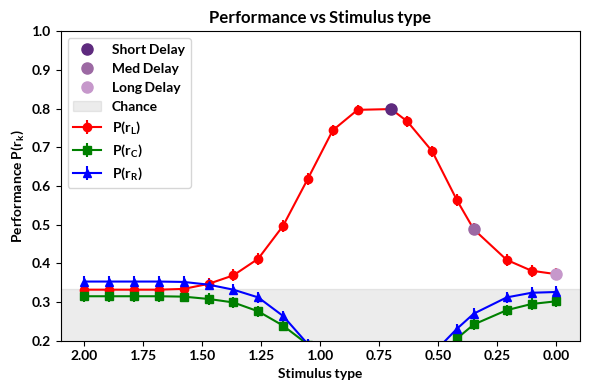

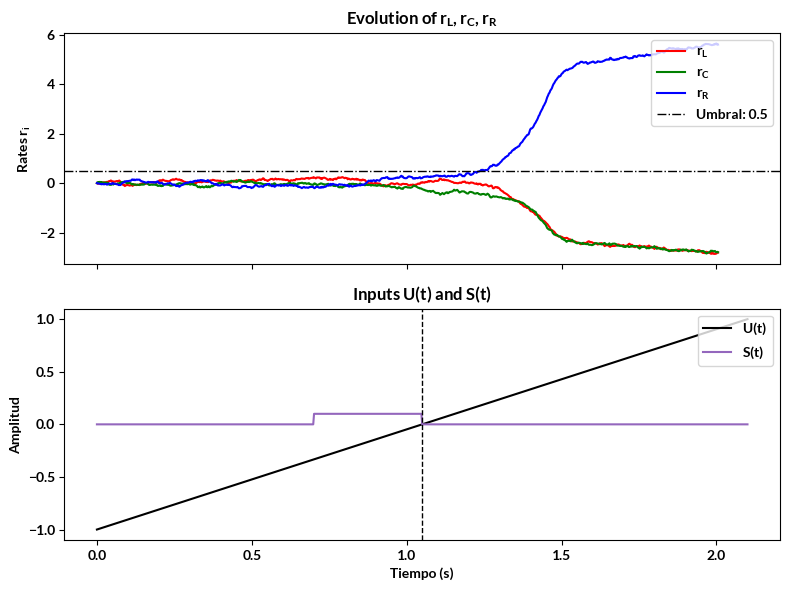

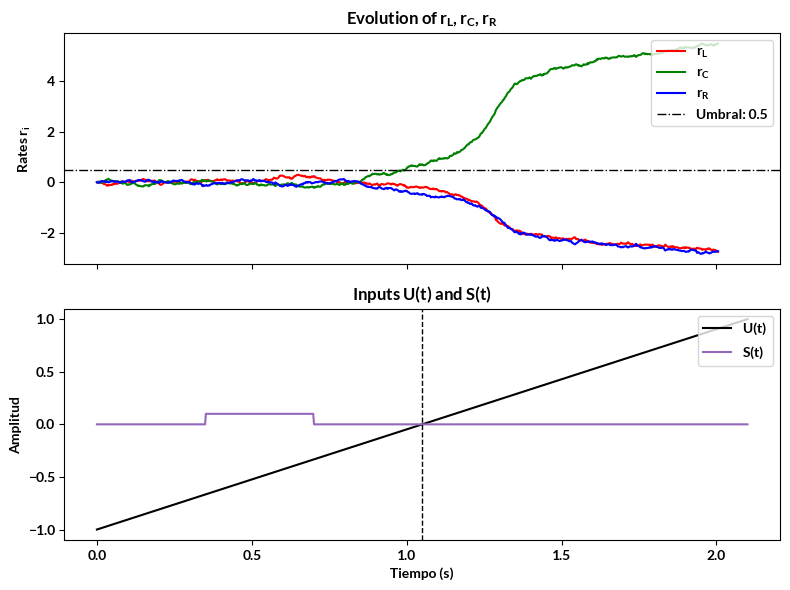

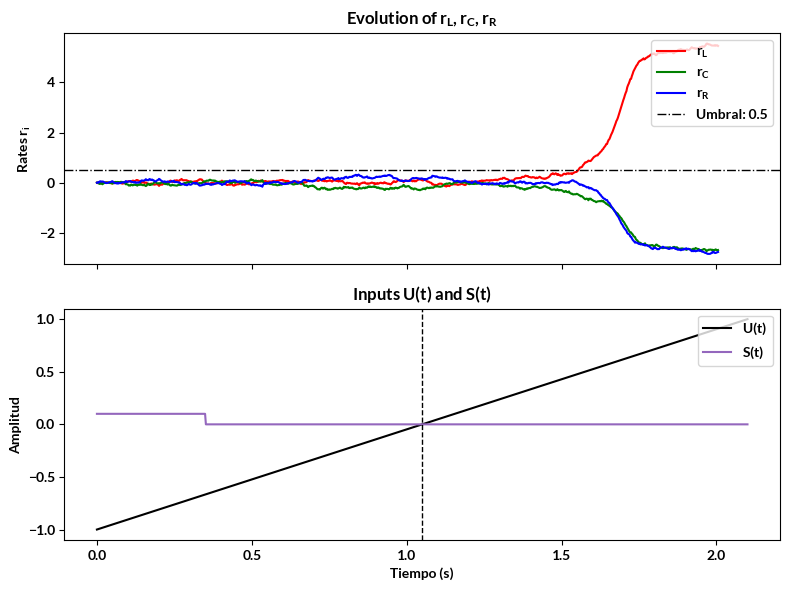

In [417]:
import numpy as np
import matplotlib.pyplot as plt
from potencial import get_expressions
from sim_helpers import parallel_sweep_general, simulate_path
# ————— Parámetros comunes —————
n_trajs = 1000
x0 = x0
values = values

# drift_factory “estándar”
def drift_factory(params):
    _, F1n, F2n, _ = get_expressions(params, type="numeric", substituted_I=False)
    return lambda X, IL, IC, IR: np.array([F1n(X[0], X[1], IL, IC, IR),
                                           F2n(X[0], X[1], IL, IC, IR)])

update_drift_fn = None  # no feedback trial-to-trial

# ————— Construir el array de onsets + t_points —————
raw_onsets   = np.linspace(0, 2, 20)
t_points     = [0.7, 0.35, 0]
mask         = np.all(np.abs(raw_onsets[:, None] - t_points) >= 0.05, axis=1)
filtered     = raw_onsets[mask]
onsets       = np.sort(np.concatenate([filtered, t_points]))

S_base = {**S_params_def, 'duration':0.35, 'amplitude' : 0.15}
U_base         = {**U_params_def, 'onset':0, 'offset':2.1}


p, p_err = parallel_sweep_general(
    sweep_list        = onsets,
    target            = 'S',
    param_key         = 'onset',
    S_params_def      = S_base,
    U_params_def      = U_base,
    x0                = x0,
    n_trajs           = n_trajs,
    init_drift_params = values,
    drift_factory     = drift_factory,
    update_drift_fn   = update_drift_fn,
    n_workers         = 10,
    Tmax             = 2.1,
)

stimd_c = ["#FFB74D", "#FB8C00", "#EF6C00"]
stimd_c = ['#5E2A7E','#9C69A3','#C698CB']
labels  = ['Short Delay','Med Delay','Long Delay']

plt.figure(figsize=(6,4))
plt.gca().invert_xaxis()

plt.errorbar(onsets, p[0], yerr=p_err[0], fmt='-o', color='red', capsize=0, label=r'$P(r_L)$')
plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(onsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=8,
             color=col, linestyle='None', zorder=5, label=lab)
            # Add a shaded area for chance level (0.33)
plt.axhspan(0, 0.333, alpha=0.15, color='gray', label='Chance')
plt.ylim(0.2, 1)
plt.xlabel('Stimulus type')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs Stimulus type')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'{plot_dir}png/performance_vs_delay_type.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_delay_type.svg')
plt.show()

X_first = []
for onset in t_points:
    X, _ = simulate_path(x0,S_params = S_base,U_params = U_base,drift= drift_factory(values),noise_amp=0.5,Tmax= 2,dt= dt)
    X_first.append(X)

for X, onset in zip(X_first, t_points):
    S_p = {**S_params_def, 'onset': onset, 'duration': 0.35}
    plot_rates(X, S_p, U_base, Tmax=2.1, dt=dt)


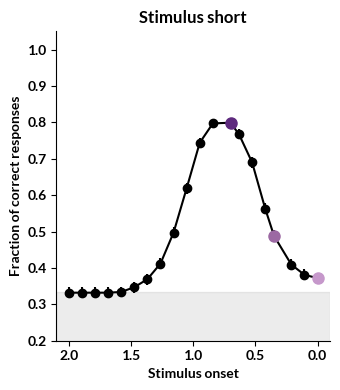

In [419]:
fig, ax = plt.subplots(figsize=(3.5, 4))
plt.gca().invert_xaxis()

plt.errorbar(onsets, p[0], yerr=p_err[0], fmt='-o', color='black', capsize=0)
# plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
# plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(onsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=8,
             color=col, linestyle='None', zorder=5, label=lab)

plt.axhspan(0, 0.333, alpha=0.15, color='gray')
plt.xlabel('Stimulus onset')
plt.ylabel('Fraction of correct responses')
plt.title('Stimulus short')
# plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0.2,1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{plot_dir}png/performance_vs_delay_type.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_delay_type.svg')
plt.show()

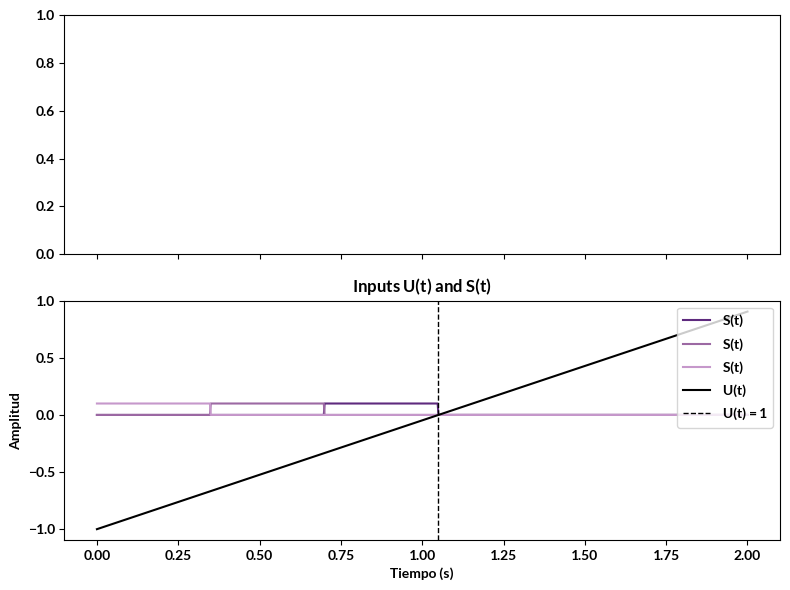

In [109]:
N       = len(X_first[0])
t       = np.arange(N) * dt
t_vals  = np.linspace(0, Tmax, N)
u_vals  = U_t(t_vals, **U_base)
stimd_c = ["#FFB74D", "#FB8C00", "#EF6C00"]
stimd_c = ['#5E2A7E','#9C69A3','#C698CB']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

for tp, col in zip(t_points, stimd_c):
    S_p = {**S_params_def, 'onset': tp, 'duration': 0.35}
    s_vals= S_t(t_vals, **S_p)
    ax2.plot(t_vals, s_vals,   linestyle='-', label=r'$S(t)$', color=col)

ax2.plot(t_vals, u_vals,   linestyle='-', label=r'$U(t)$', color=u_color)
onset     = U_base.get('onset', 0.5)
duration  = U_base.get('duration', -1)
offset    = U_base.get('offset', 1.5)
amplitude = U_base.get('amplitude', 2)
if duration < 0:
    duration = offset - onset
t_cross = onset + duration / amplitude
ax2.axvline(t_cross, color='k', linestyle='--', linewidth=1, label=r'$U(t)=1$')
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Amplitud')
ax2.set_title('Inputs $U(t)$ and $S(t)$')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### S Offset

Simulating for different offsets: 100%|██████████| 10/10 [01:42<00:00, 10.25s/it]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/2803231693.py:32: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.tight_layout()
/opt/homebrew/anaconda3/envs/pynamical/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  func(*args, **kwargs)


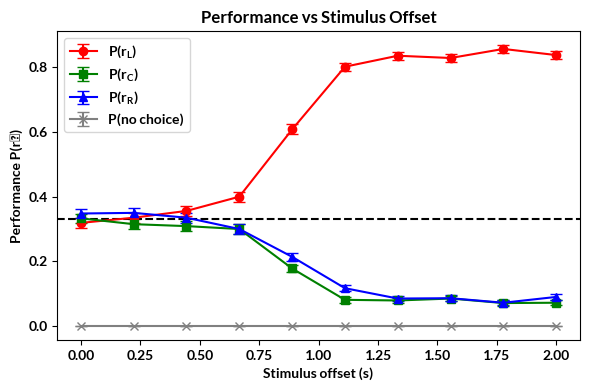

In [ ]:
offsets = np.linspace(0, 2.0, 10)

stimd_c = ['#230027','#5E2A7E','#9C69A3','#C698CB', '#EFD9F5']
labels =["Visual", "Easy", "Medium", "Hard", "No stimulus"]
t_points     = [2, 1, 0.55,0.35]

p = np.zeros((4, len(offsets)))
X_first = [] 
for j, offset in enumerate(tqdm(offsets, desc="Simulating for different offsets")):
    S_params = {**S_params_def, 'duration': offset}
    wins = {'r1':0,'r2':0,'r3':0, 'none': 0}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_params=S_params, U_params=U_params_def, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p[:,j] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_err = np.sqrt(p * (1 - p) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(offsets, p[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(offsets, p[1], yerr=p_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(offsets, p[2], yerr=p_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(offsets, p[3], yerr=p_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.axhline(0.33, color='black', linestyle='--', label='')
plt.xlabel('Stimulus offset (s)')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs Stimulus Offset')
plt.legend()
plt.tight_layout()

for X, offset in zip(X_first, offsets):
    S_params = {**S_params_def, 'duration': offset}
    plot_rates(X, S_params, U_params_def, Tmax=2, dt=dt)


Parallel sweep using 10 workers: 100%|██████████| 21/21 [00:36<00:00,  1.73s/it]


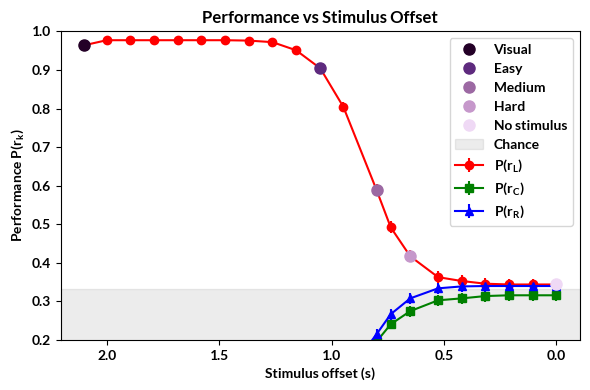

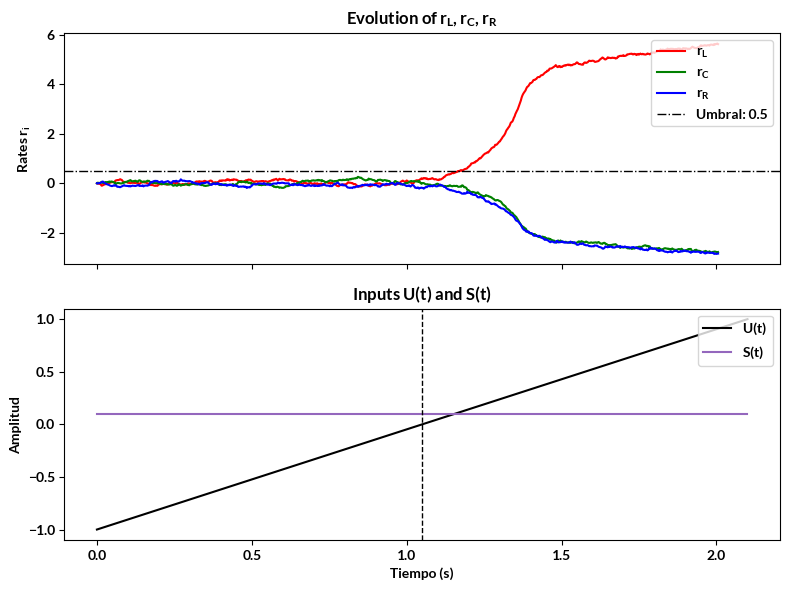

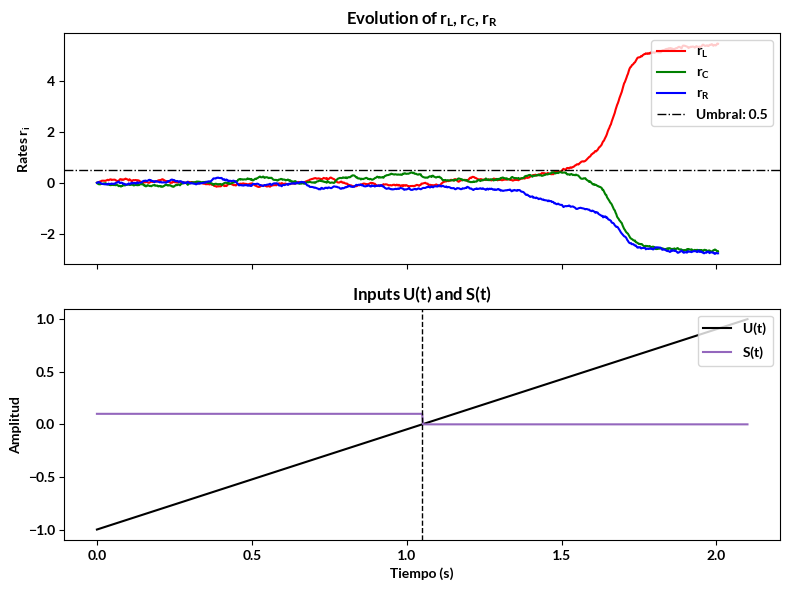

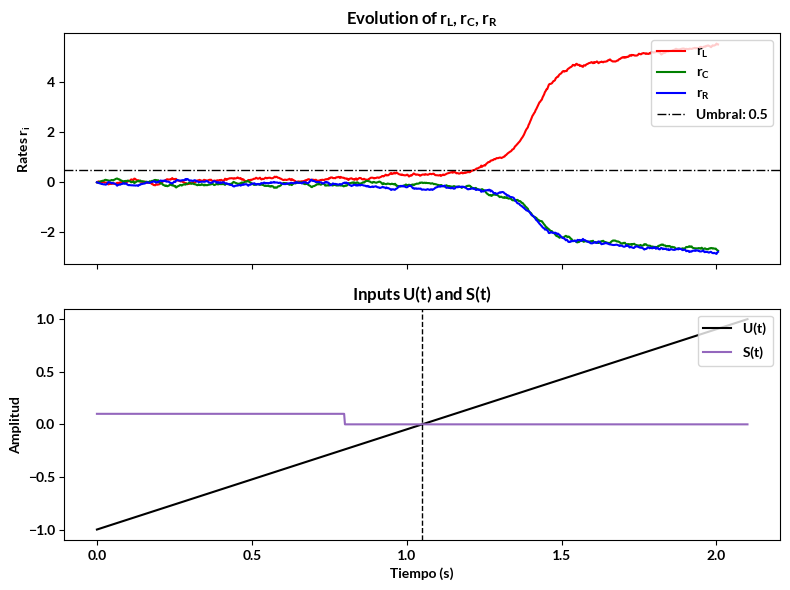

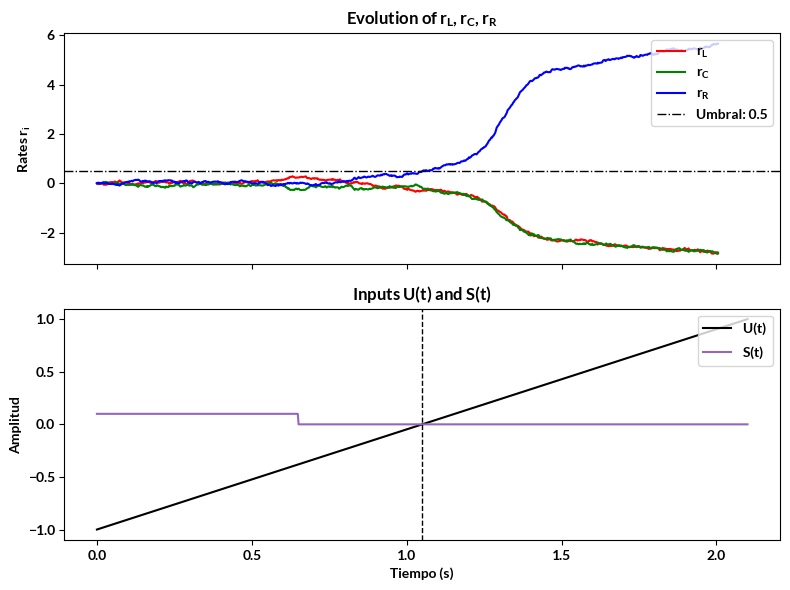

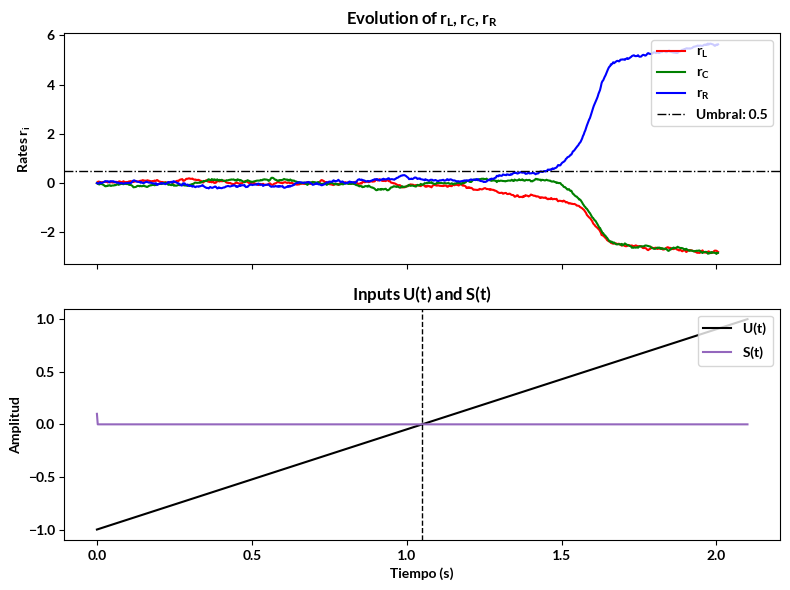

In [385]:
raw_offsets = np.linspace(0, 2.0, 20)
t_points     = [2.1, 1.05, 0.8,0.65,0 ]
mask         = np.all(np.abs(raw_offsets[:, None] - t_points) >= 0.05, axis=1)
filtered     = raw_offsets[mask]
offsets       = np.sort(np.concatenate([filtered, t_points]))
U_base         = {**U_params_def, 'onset':0, 'offset':2.1}
stimd_c = ['#230027','#5E2A7E','#9C69A3','#C698CB', '#EFD9F5']
labels =["Visual", "Easy", "Medium", "Hard", "No stimulus"]
S_base["onset"] = 0
S_base["amplitude"] = 0.15
S_base["duration"] = -1
p, p_err = parallel_sweep_general(
    sweep_list        = offsets,
    target            = 'S',
    param_key         = 'offset',
    S_params_def      = S_base,
    U_params_def      = U_base,
    x0                = x0,
    n_trajs           = n_trajs,
    init_drift_params = values,
    drift_factory     = drift_factory,
    update_drift_fn   = update_drift_fn,
    n_workers         = 10,
    Tmax             = 2.1,
)

plt.figure(figsize=(6,4))
plt.gca().invert_xaxis()

plt.errorbar(offsets, p[0], yerr=p_err[0], fmt='-o', color='red', capsize=0, label=r'$P(r_L)$')
plt.errorbar(offsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
plt.errorbar(offsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(offsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=8,
             color=col, linestyle='None', zorder=5, label=lab)
    
plt.axhspan(0, 0.333, alpha=0.15, color='gray', label='Chance')
plt.ylim(0.2, 1)
plt.xlabel('Stimulus offset (s)')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs Stimulus Offset')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('performance_vs_stim_offset.png', dpi=300)
plt.show()

X_first = []
for offset in t_points:
    S_base = {**S_params_def, 'duration': offset, 'onset':0}
    X, _ = simulate_path(x0, S_params = S_base, U_params = U_base, drift= drift_factory(values),noise_amp=0.5,Tmax= 2,dt= dt)
    plot_rates(X, S_base, U_base, Tmax=2.1, dt=dt)

# for X, offset in zip(X_first, t_points):
#     S_base = {**S_params_def, 'duration': offset}
   


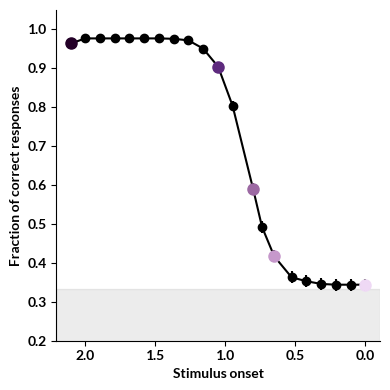

In [386]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.gca().invert_xaxis()

plt.errorbar(offsets, p[0], yerr=p_err[0], fmt='-o', color='black', capsize=0)
# plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
# plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(offsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=8,
             color=col, linestyle='None', zorder=5, label=lab)

plt.axhspan(0, 0.333, alpha=0.15, color='gray')
plt.xlabel('Stimulus onset')
plt.ylabel('Fraction of correct responses')
plt.title('')
# plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0.2,1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{plot_dir}png/performance_vs_stimulus_offset.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_stimulus_offset.svg')
plt.show()

In [193]:
dt      = tau / 40
Tmax    = 2.0
n_trajs = 1000
x0      = np.array([0., 0.])
noise_amp = 1

# Visually guided
S_params_def = {
    "onset": 0.3,
    "offset": 2.1,
    "duration": -1,
    "amplitude": 0.1
}
U_params_def = {
    "onset": 0.5,
    "offset": 2.1,
    "amplitude": 2,
    "duration": -1
} 

onset_fix= 0.3
offset_fix= 2
duration_fix = 0.3
U_amp_fix = 2
U_onset = 0.5

In [ ]:
S_params_VG = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DS = {
    "onset": 1.7,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DM = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_DL = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_SS = {
    "onset": 1.7,
    "offset": 2,
    "duration": 0.3,
    "amplitude": 0.1
}
S_params_SM = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}
S_params_SL = {
    "onset": 0.3,
    "offset": 2,
    "duration": -1,
    "amplitude": 0.1
}

### U Amplitude

Parallel sweep using 10 workers: 100%|██████████| 20/20 [00:25<00:00,  1.29s/it]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3948713296.py:33: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.tight_layout()
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3948713296.py:34: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.savefig(f'{plot_dir}png/performance_vs_U_amplitude.png', dpi=300)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3948713296.py:35: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.savefig(f'{plot_dir}svg/performance_vs_U_amplitude.svg')


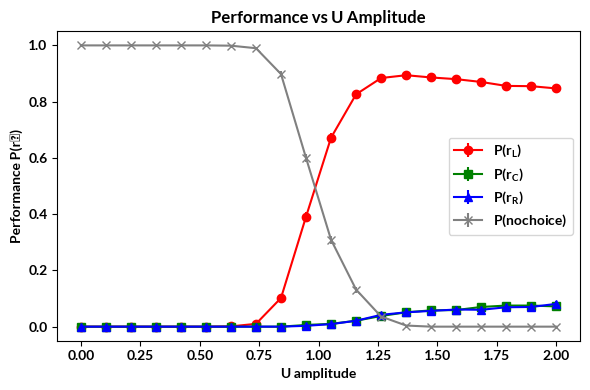

In [ ]:
amplitudes= np.linspace(0, 2.0, 20)
S_base = {**S_params_def, 'onset': 0.3}
U_base = U_params_def.copy()
p, p_err = parallel_sweep_general(
    sweep_list        = amplitudes,
    target            = 'U',
    param_key         = 'amplitude',
    S_params_def      = S_base,
    U_params_def      = U_base,
    x0                = x0,
    n_trajs           = n_trajs,
    init_drift_params = values,
    drift_factory     = drift_factory,
    update_drift_fn   = update_drift_fn,
    n_workers         = 10,
    Tmax             = 2.1,
)

plt.figure(figsize=(6,4))
# plt.gca().invert_xaxis()

plt.errorbar(amplitudes, p[0], yerr=p_err[0], fmt='-o', color='red', capsize=0, label=r'$P(r_L)$')
plt.errorbar(amplitudes, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
plt.errorbar(amplitudes, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')
plt.errorbar(amplitudes, p[3], yerr=p_err[3], fmt='-x', color='gray', capsize=0, label=r'$P(no choice)$')

# plt.axhspan(0, 0.333, alpha=0.15, color='gray', label='Chance')
# plt.ylim(0.2, 1)
plt.xlabel('U amplitude')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs U Amplitude')
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}png/performance_vs_U_amplitude.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_U_amplitude.svg')
plt.show()



Simulating for different U amplitudes: 100%|██████████| 20/20 [03:28<00:00, 10.45s/it]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/3172977218.py:32: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.tight_layout()
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/3172977218.py:33: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.savefig('performance_vs_U_amplitude.png', dpi=300)


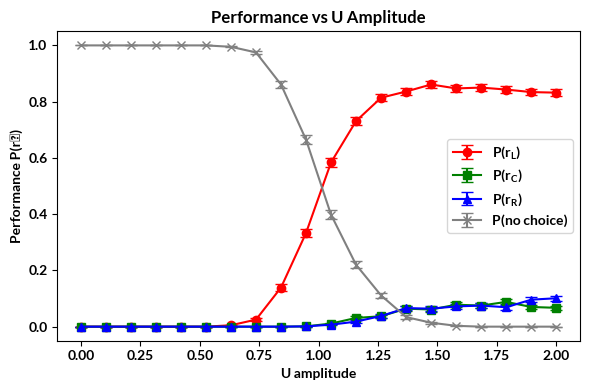

/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/1398700463.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_line = onset + duration / amplitude


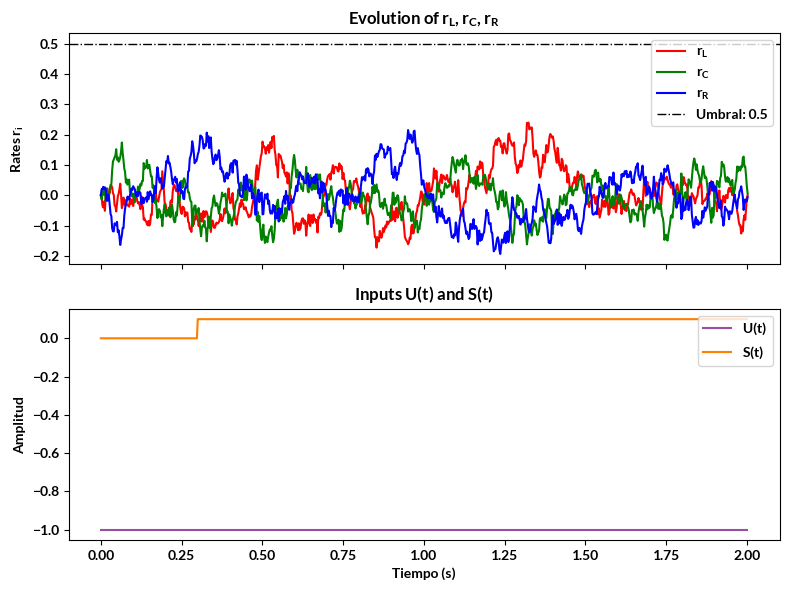

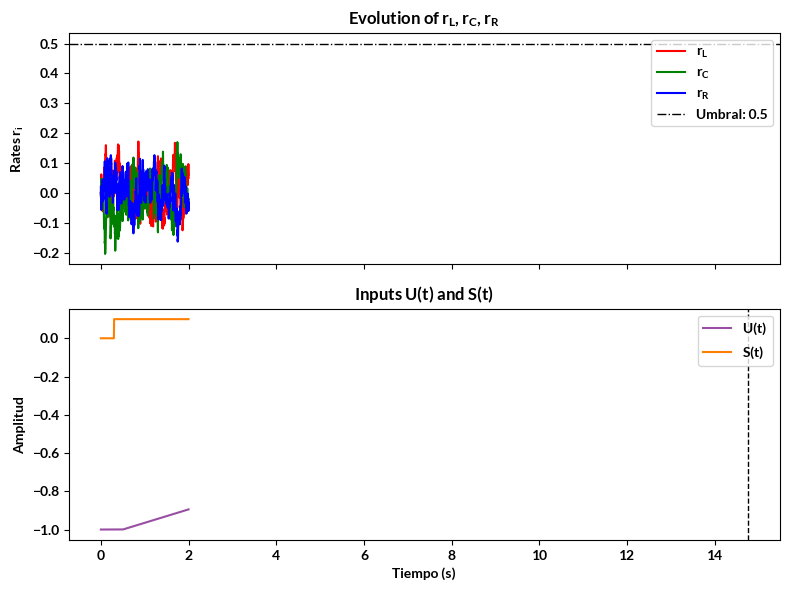

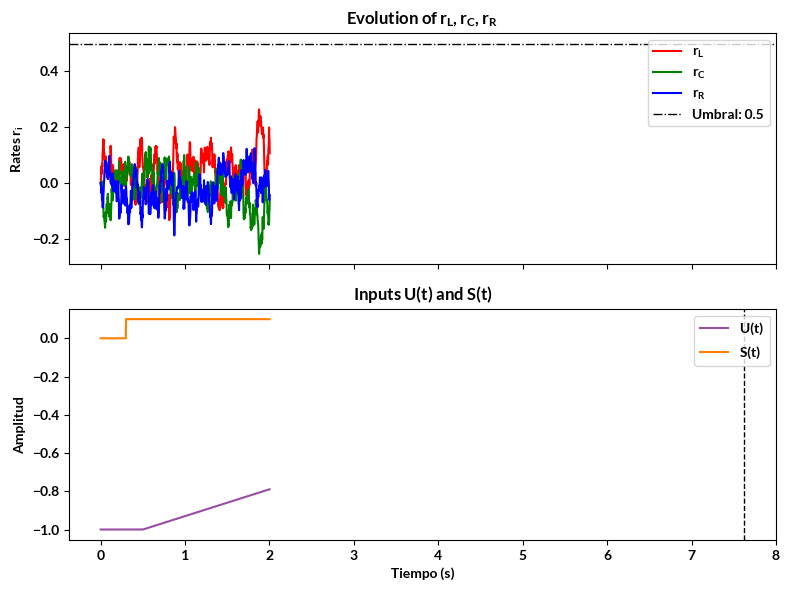

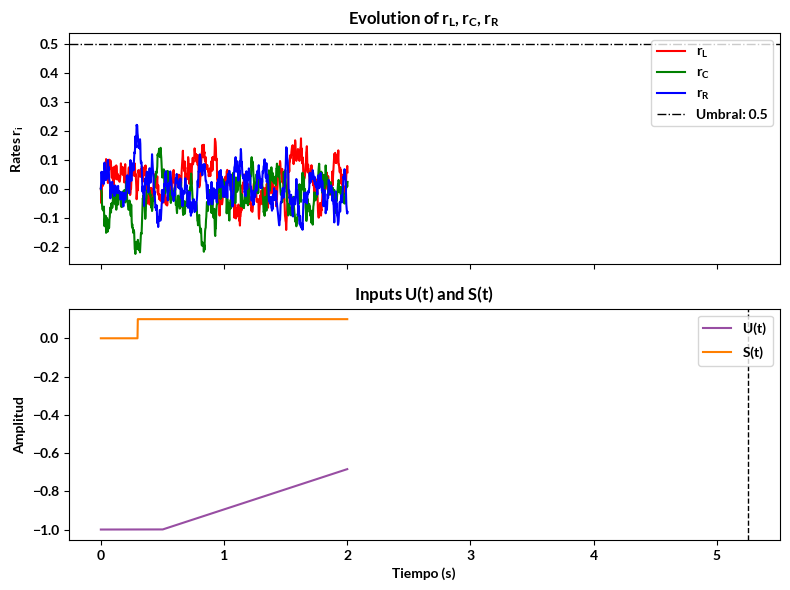

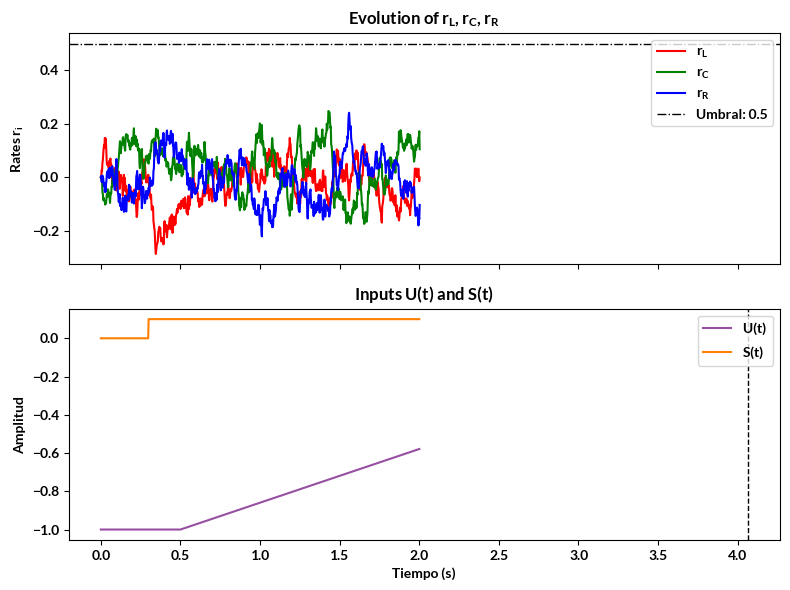

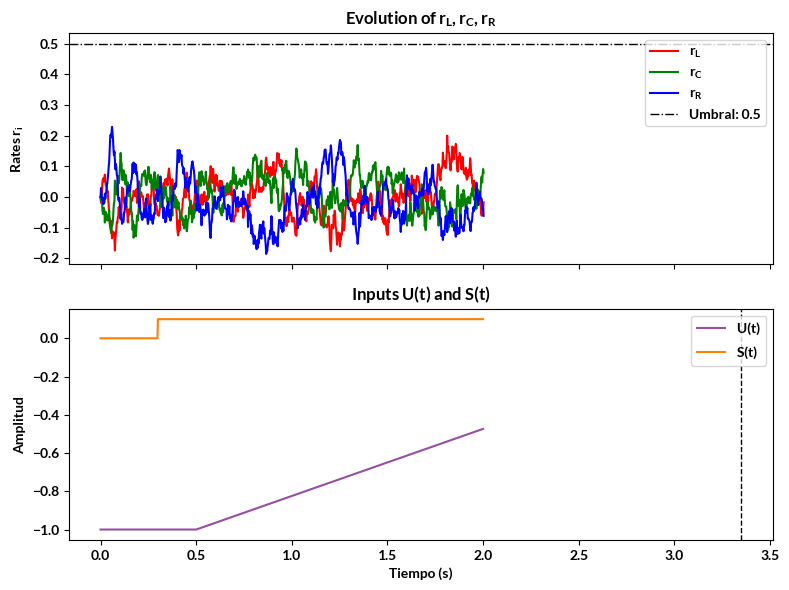

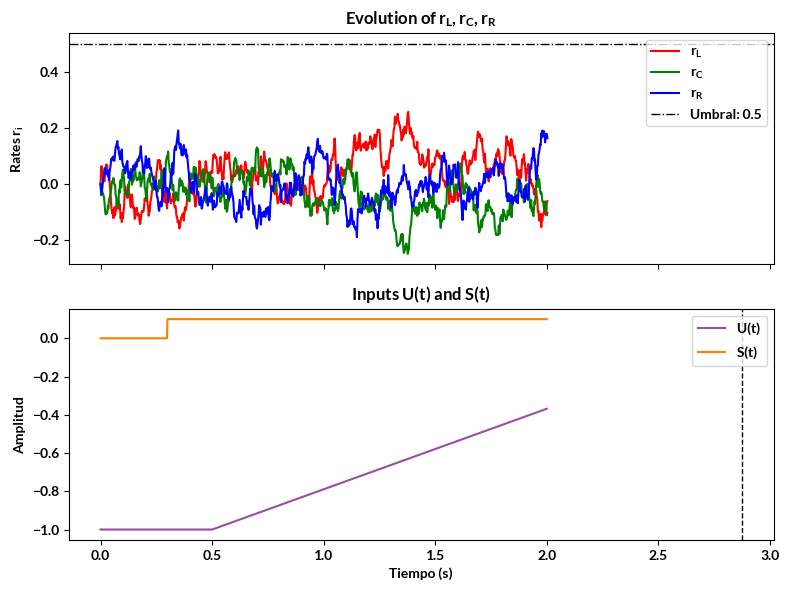

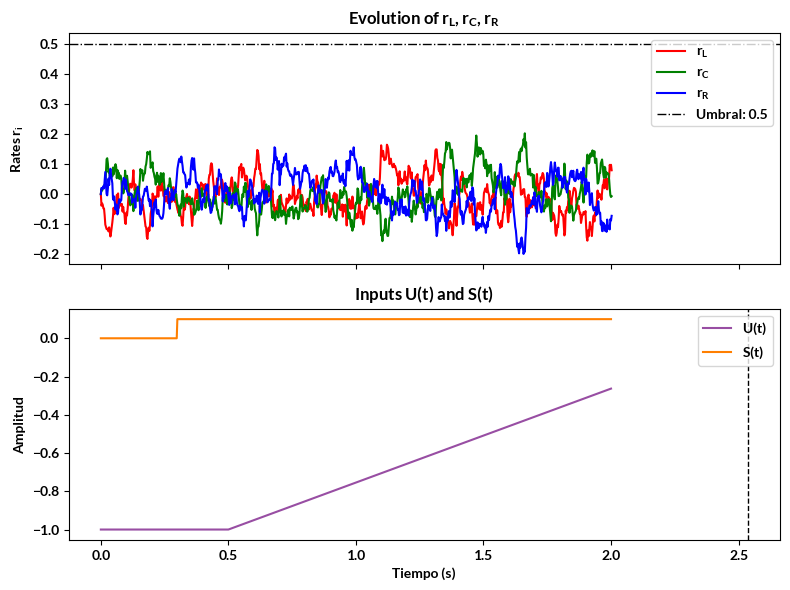

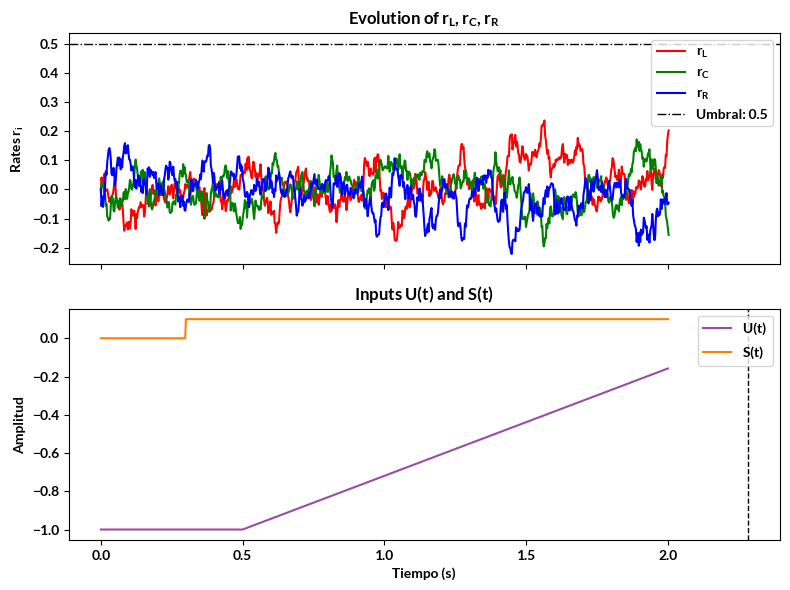

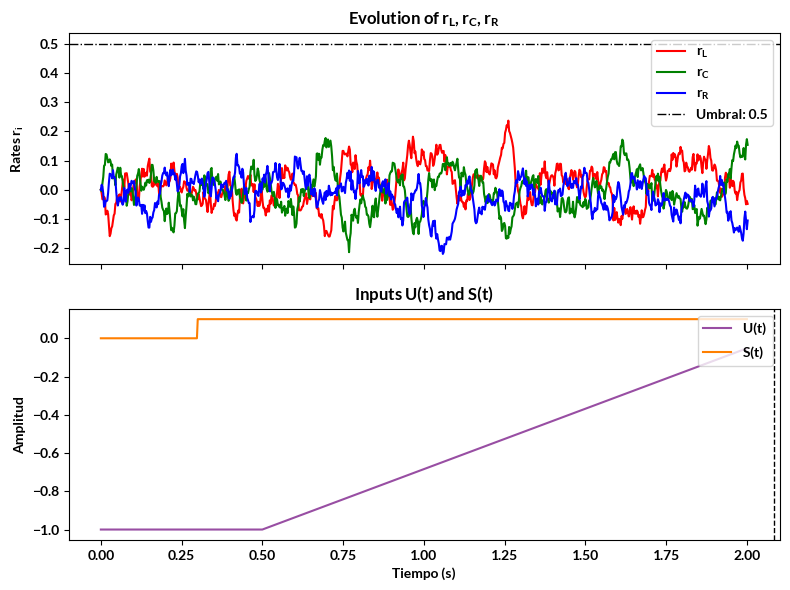

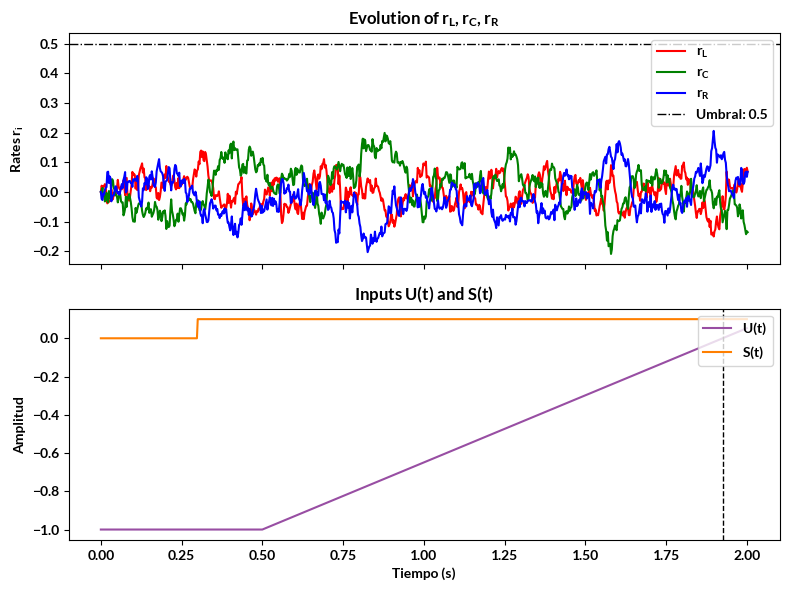

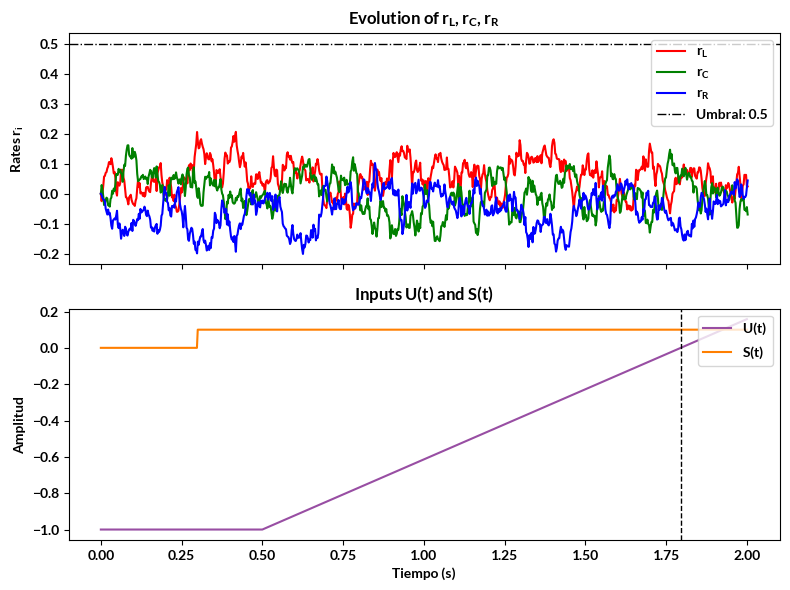

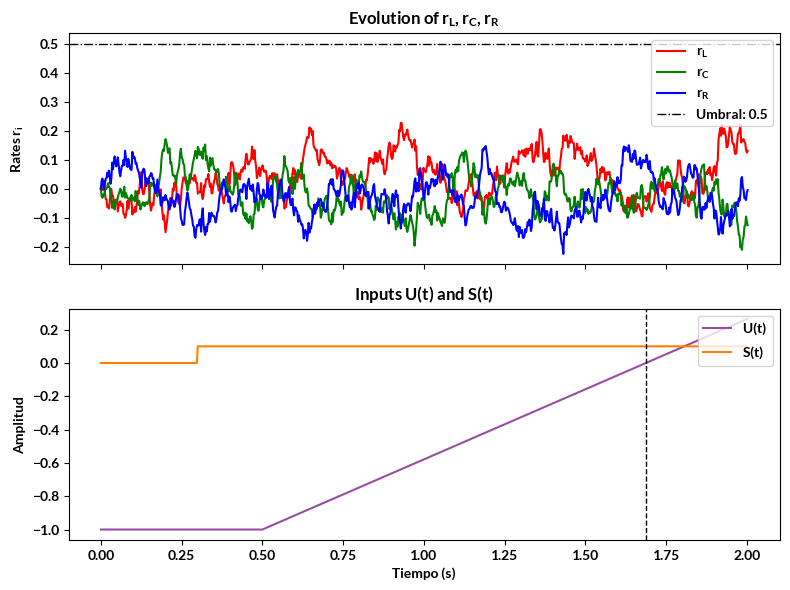

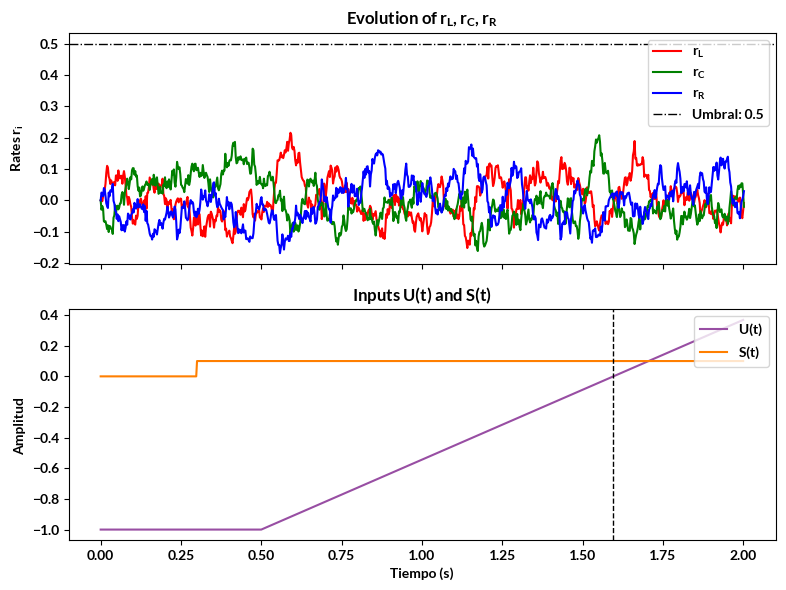

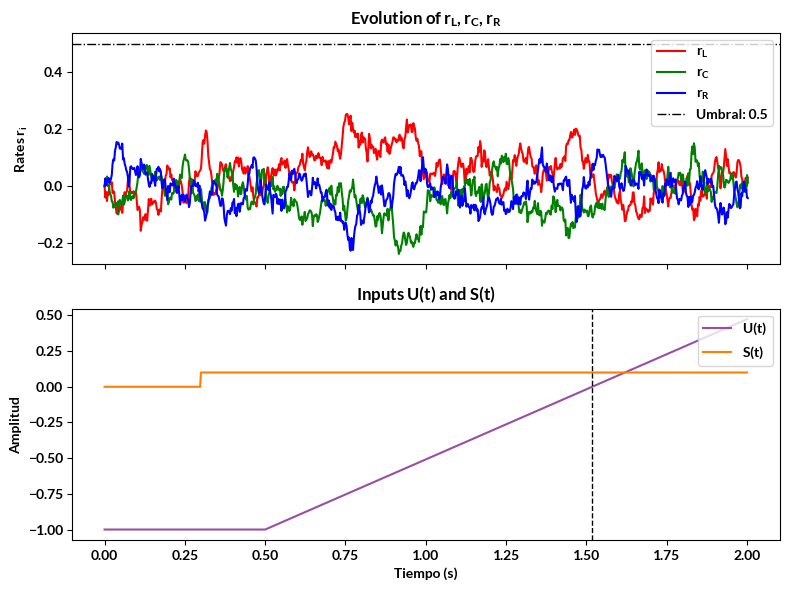

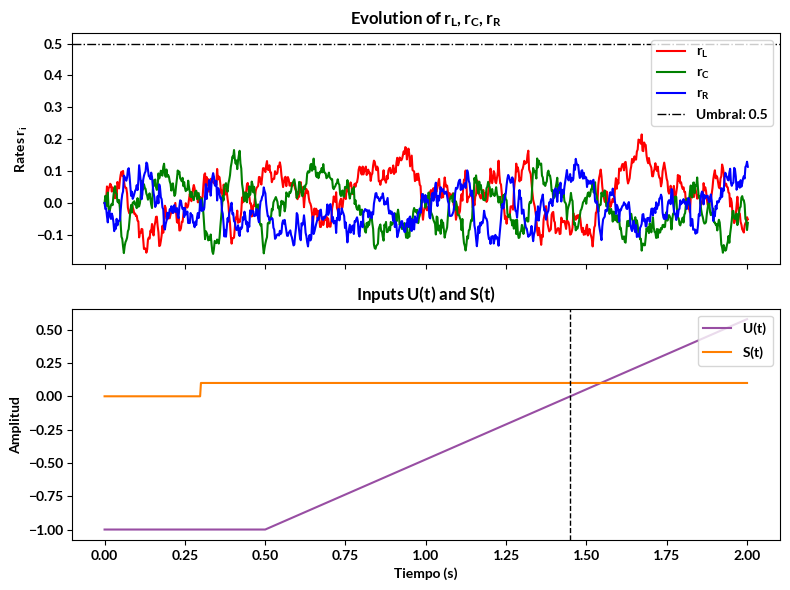

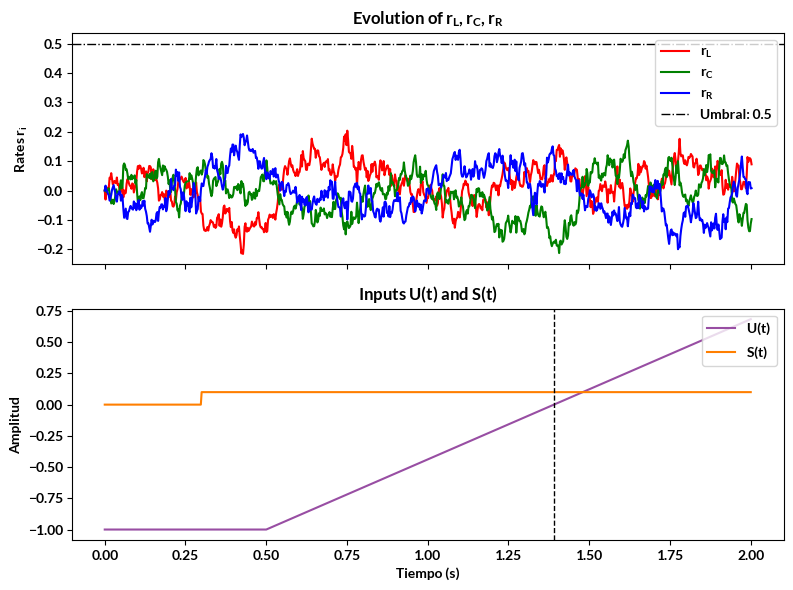

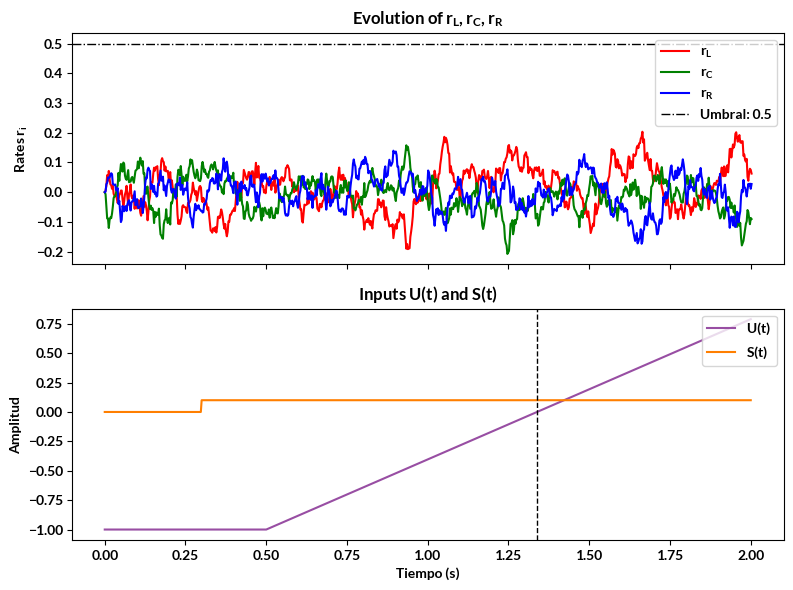

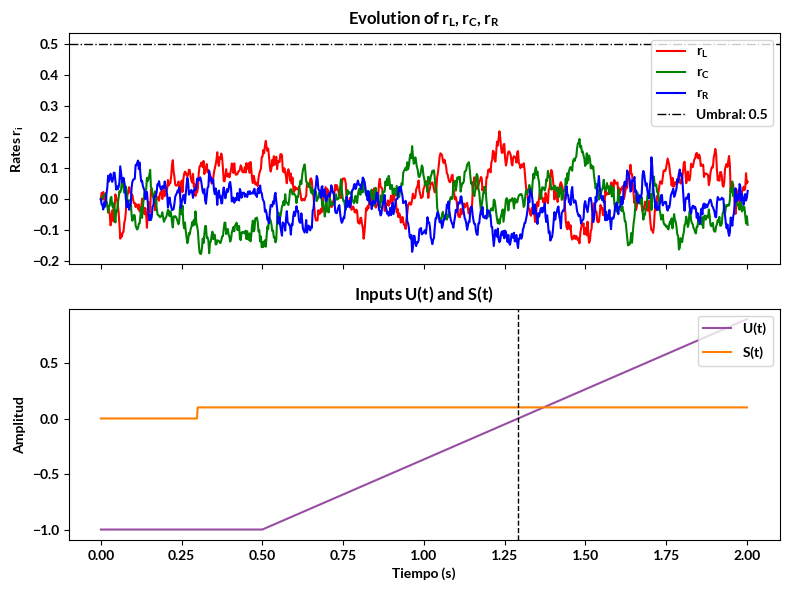

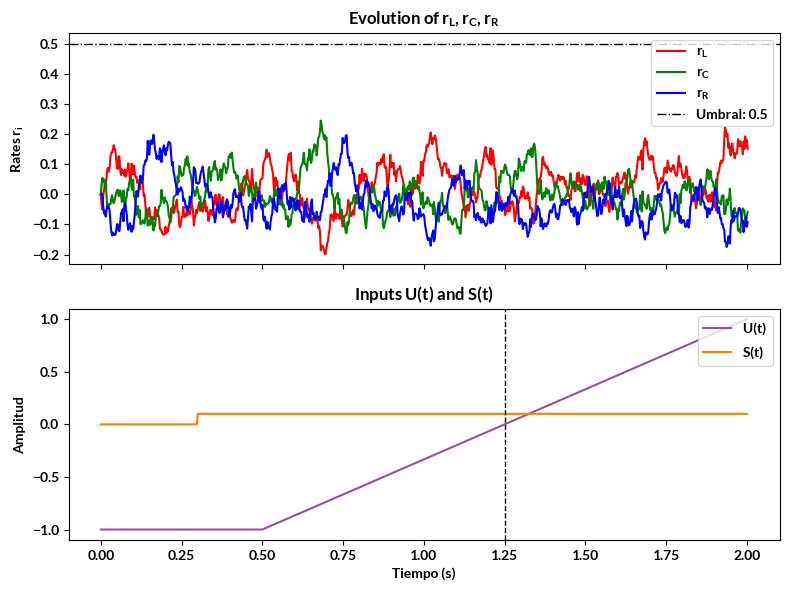

In [ ]:
amplitudes= np.linspace(0, 2.0, 20)
S_params = {**S_params_def, 'onset': 0.3}
S_params  = S_params_DL
p = np.zeros((4, len(amplitudes)))
X_first = [] 
for k, amplitude in enumerate(tqdm(amplitudes, desc="Simulating for different U amplitudes")):
    wins = {'r1':0,'r2':0,'r3':0,'none': 0}
    U_params = {**U_params_def, 'amplitude': amplitude}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_params=S_params, U_params=U_params, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p[:,k] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_err = np.sqrt(p * (1 - p) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(amplitudes, p[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(amplitudes, p[1], yerr=p_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(amplitudes, p[2], yerr=p_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(amplitudes, p[3], yerr=p_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.xlabel('U amplitude')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs U Amplitude')
plt.legend()
plt.tight_layout()
plt.savefig('performance_vs_U_amplitude.png', dpi=300)
plt.show()

for X, amplitude in zip(X_first, amplitudes):
    U_params = {**U_params_def, 'amplitude': amplitude}
    plot_rates(X, S_params=S_params, U_params= U_params, Tmax=2, dt =dt)

### U onset

Parallel sweep using 10 workers: 100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


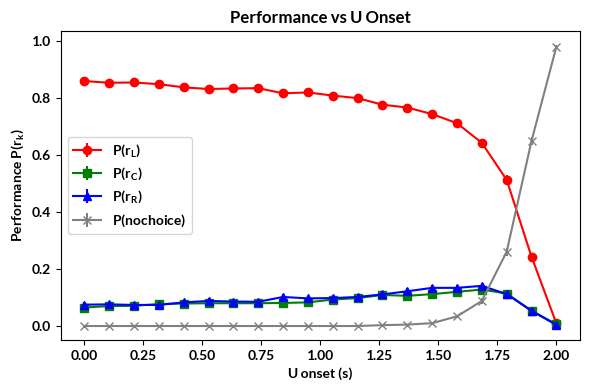

In [ ]:
onsets    = np.linspace(0.0, 2.0, 20)
S_base = S_params_def.copy()
U_base = U_params_def.copy()
p, p_err = parallel_sweep_general(
    sweep_list        = onsets,
    target            = 'U',
    param_key         = 'onset',
    S_params_def      = S_base,
    U_params_def      = U_base,
    x0                = x0,
    n_trajs           = n_trajs,
    init_drift_params = values,
    drift_factory     = drift_factory,
    update_drift_fn   = update_drift_fn,
    n_workers         = 10,
    Tmax             = 2.1,
)

plt.figure(figsize=(6,4))
# plt.gca().invert_xaxis()
plt.errorbar(onsets, p[0], yerr=p_err[0], fmt='-o', color='red', capsize=0, label=r'$P(r_L)$')
plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')
plt.errorbar(onsets, p[3], yerr=p_err[3], fmt='-x', color='gray', capsize=0, label=r'$P(no choice)$')

# plt.axhspan(0, 0.333, alpha=0.15, color='gray', label='Chance')
# plt.ylim(0.2, 1)
plt.xlabel('U onset (s)')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs U Onset')
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}png/performance_vs_U_onset.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_U_onset.svg')
plt.show()



### Noise Amplitude

Simulating for different noise amp: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/2632369842.py:29: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.tight_layout()


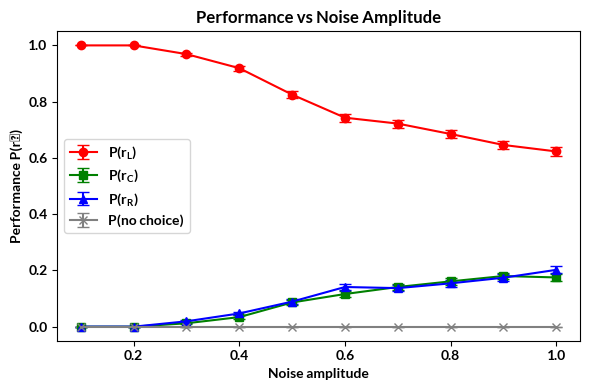

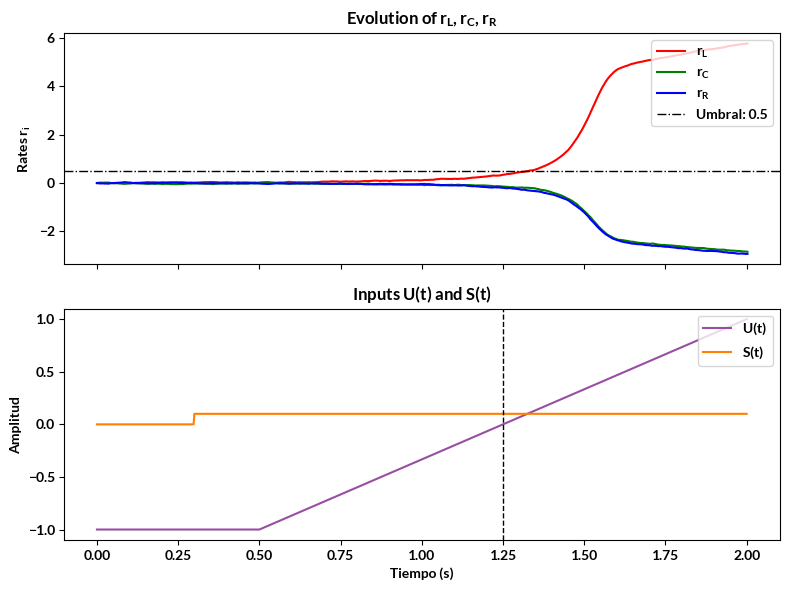

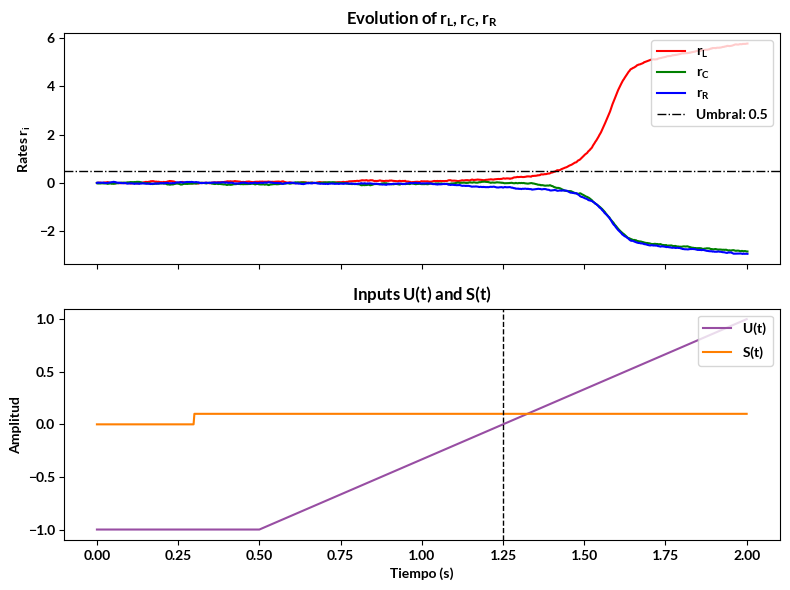

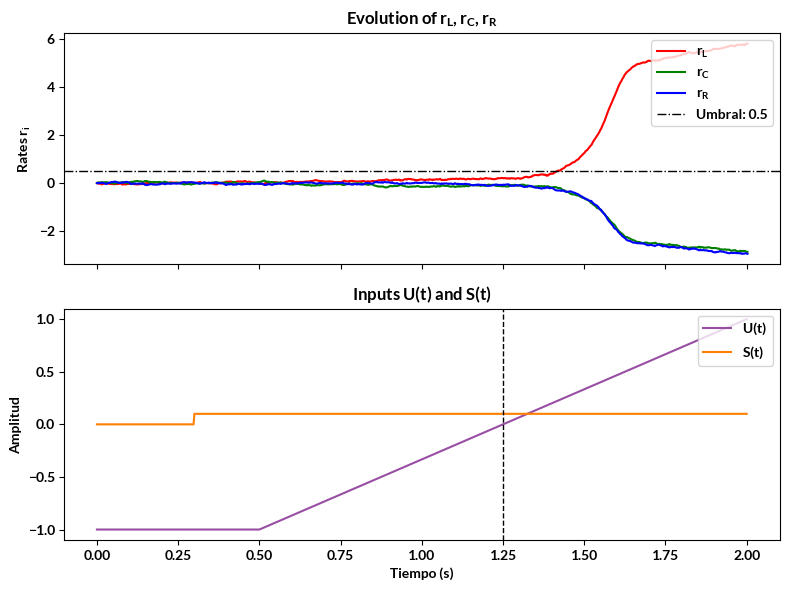

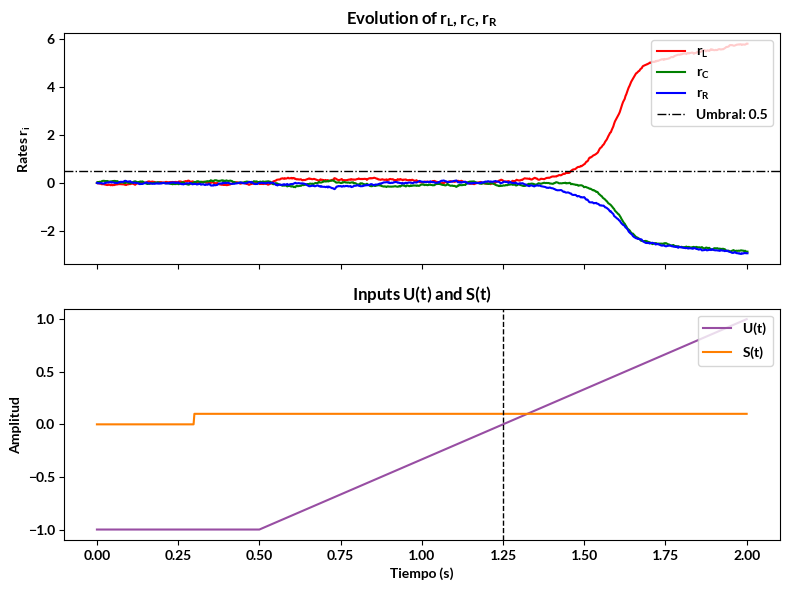

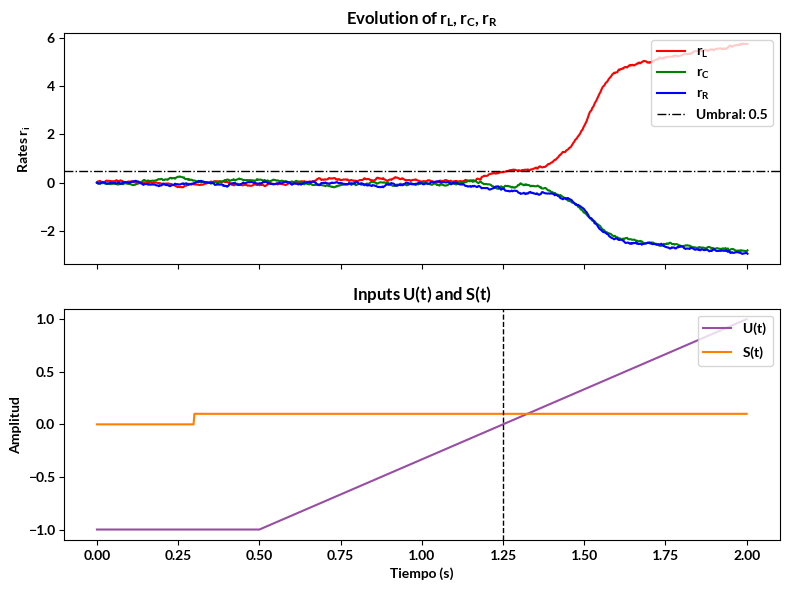

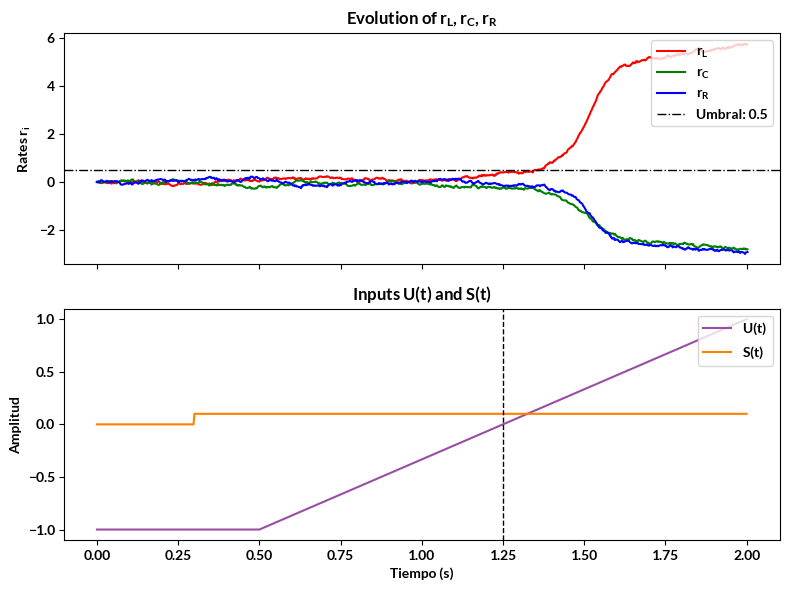

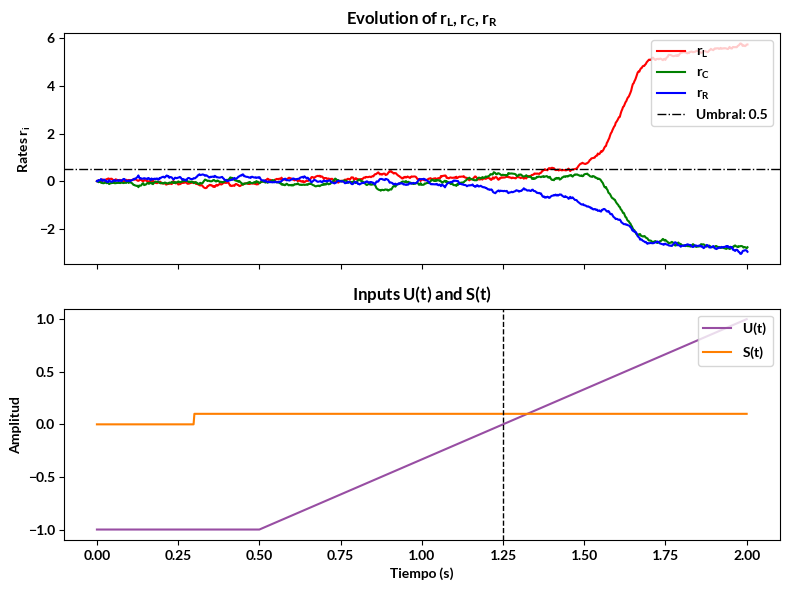

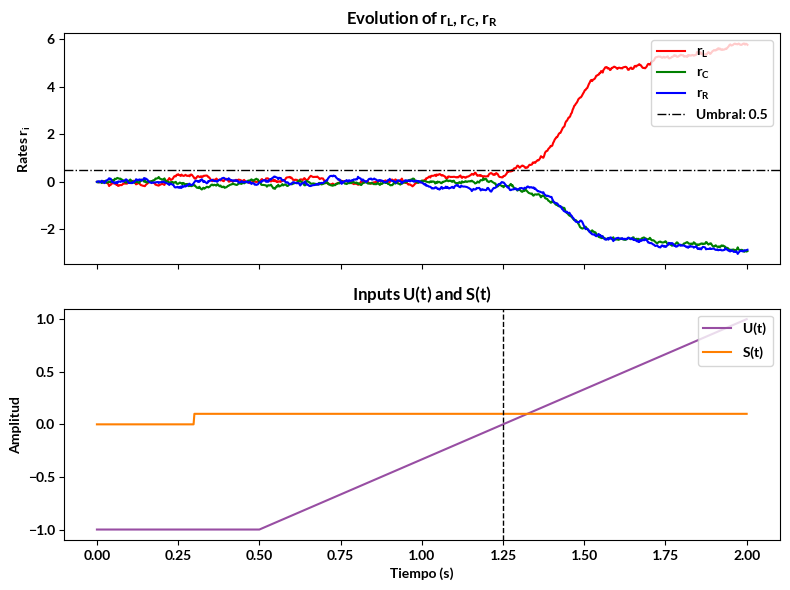

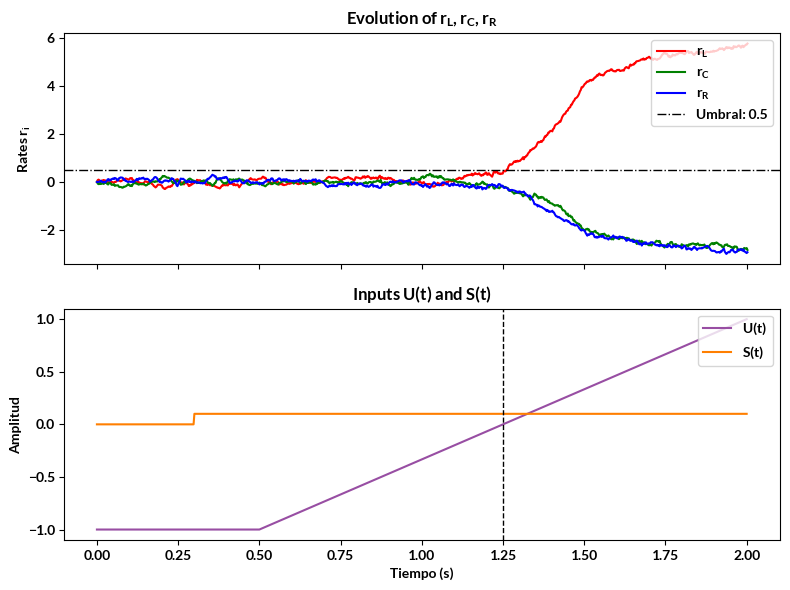

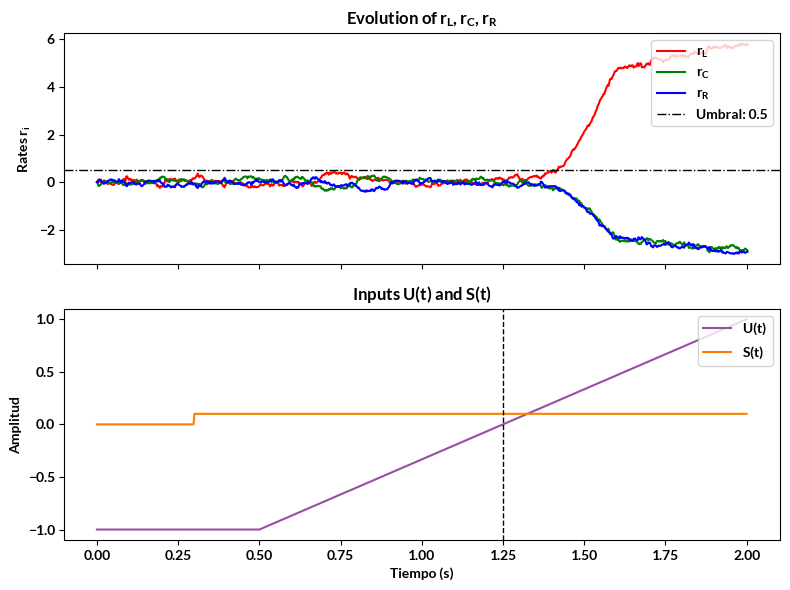

In [ ]:
noise_amps = np.linspace(0.1, 1.0, 10)
p = np.zeros((4, len(noise_amps)))
X_first = [] 
for i, amp in enumerate(tqdm(noise_amps, desc="Simulating for different noise amp")):
    wins = {'r1': 0, 'r2': 0, 'r3': 0, 'none': 0}
    for k in range(n_trajs):
        X, w = simulate_path(x0, S_params = S_params_def, U_params = U_params_def, noise_amp=amp, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p[:, i] = [wins['r1'] / total, wins['r2'] / total, wins['r3'] / total, wins['none'] / total]

p_err = np.sqrt(p * (1 - p) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(noise_amps, p[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(noise_amps, p[1], yerr=p_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(noise_amps, p[2], yerr=p_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(noise_amps, p[3], yerr=p_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.xlabel('Noise amplitude')
plt.ylabel(r'Performance P($r_\mathrm{k}$)')
plt.title('Performance vs Noise Amplitude')
plt.legend()
plt.tight_layout()

for X, amp in zip(X_first, noise_amps):
    plot_rates(X, S_params_def, U_params_def, Tmax=2, dt=dt, )


## Replicating Stimulus type

Simulating for different U amplitudes: 100%|██████████| 10/10 [08:06<00:00, 48.63s/it]
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/2872379653.py:31: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.tight_layout()
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_6928/2872379653.py:32: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  plt.savefig('performance_vs_stimulus_type.png', dpi=300)
/opt/homebrew/anaconda3/envs/pynamical/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7522 (\N{LATIN SUBSCRIPT SMALL LETTER I}) missing from font(s) Lato.
  fig.canvas.print_figure(bytes_io, **kw)


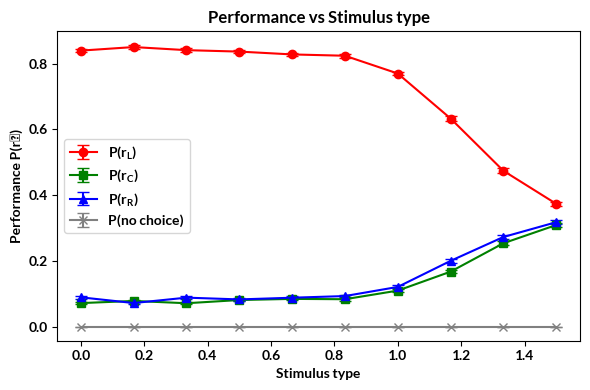

In [102]:
onsets    = np.linspace(0, 1.5, 10)
n_trajs = 5000
p = np.zeros((4, len(onsets)))
X_first = [] 
for k, onset in enumerate(tqdm(onsets, desc="Simulating for different Stimulus types")):
    S_params = {**S_params_def, 'onset': onset, 'offset': 2}
    wins = {'r1':0,'r2':0,'r3':0,'none': 0}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_params, U_params_def, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p[:,k] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_err = np.sqrt(p * (1 - p) / n_trajs)

plt.figure(figsize=(6,4))
plt.errorbar(onsets, p[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='red',   capsize=4)
plt.errorbar(onsets, p[1], yerr=p_err[1],
             fmt='-s', label=r'$P(r_C)$', color='green', capsize=4)
plt.errorbar(onsets, p[2], yerr=p_err[2],
             fmt='-^', label=r'$P(r_R)$', color='blue',  capsize=4)
plt.errorbar(onsets, p[3], yerr=p_err[3],
             fmt='-x', label='P(no choice)', color='gray', capsize=4)
plt.xlabel('Stimulus type')
plt.ylabel('Performance P(rᵢ)')
plt.title('Performance vs Stimulus type')
plt.legend()
plt.tight_layout()
plt.savefig('performance_vs_stimulus_type.png', dpi=300)
plt.show()

# for X, onset in zip(X_first, onsets):
#     S_params = {**S_params_def, 'onset': onset, 'offset': 2}
#     plot_rates(X, S_params, U_params_def, Tmax=2, dt =dt)

In [389]:
onsets    = np.linspace(0, 1.5, 10)
stimd_c = ["#FFB74D", "#FB8C00", "#EF6C00"] 
ttypes_c = ['#230027','#5E2A7E','#9C69A3','#C698CB', '#EFD9F5']
t_points = [0.3, 0.65, 1]
mask = np.all(np.abs(onsets[:, None] - t_points) >= 0.1, axis=1)
filtered_onsets = onsets[mask]
onsets = np.sort(np.concatenate([filtered_onsets, t_points]))


p = np.zeros((4, len(onsets)))
X_first = [] 
for k, onset in enumerate(tqdm(onsets, desc="Simulating for different U amplitudes")):
    S_params = {**S_params_def, 'onset': onset, 'offset': 1.35}
    if onset == 0: 
        S_params = {**S_params_def, 'duration': -1, 'offset': 2}
    wins = {'r1':0,'r2':0,'r3':0,'none': 0}
    for _ in range(n_trajs):
        X ,w = simulate_path(x0, S_params, U_params_def, noise_amp=0.5, Tmax=2)
        wins[w] += 1
        if k == 0:
            X_first.append(X.copy())
    total = float(n_trajs)
    p[:,k] = [wins['r1']/total, wins['r2']/total, wins['r3']/total, wins['none']/total]

p_err = np.sqrt(p * (1 - p) / n_trajs)



Simulating for different U amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

Simulating for different U amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: simulate_path() missing 1 required positional argument: 'drift'

Parallel sweep using 10 workers: 100%|██████████| 19/19 [00:24<00:00,  1.27s/it]


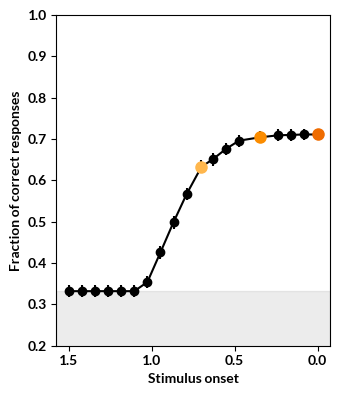

In [390]:
# ————— Parámetros comunes —————
n_trajs = 1000
x0 = x0  # tu estado inicial
values = values  # tu dict simbólico de parámetros

# drift_factory “estándar”
def drift_factory(params):
    _, F1n, F2n, _ = get_expressions(params, type="numeric", substituted_I=False)
    return lambda X, IL, IC, IR: np.array([F1n(X[0], X[1], IL, IC, IR),
                                           F2n(X[0], X[1], IL, IC, IR)])

update_drift_fn = None  # no feedback trial-to-trial

# ————— Construir el array de onsets + t_points —————
raw_onsets   = np.linspace(0, 1.5, 20)
t_points     = [0.35, 0.7, 1.05]
t_points     = [0, 0.35, 0.7]
mask         = np.all(np.abs(raw_onsets[:, None] - t_points) >= 0.05, axis=1)
filtered     = raw_onsets[mask]
onsets       = np.sort(np.concatenate([filtered, t_points]))

# ————— 1) Barrido con parallel_sweep_general para todos los onsets **≠0** —————
#    Usamos offset=1.35 y duration fija, override sólo onset
S_base_nonzero = {**S_params_def, 'offset': 1.05, 'duration': -1}
U_base         = U_params_def
U_base["onset"] = 0
U_base["offset"] = 2.1

p, p_err = parallel_sweep_general(
    sweep_list        = onsets,
    target            = 'S',
    param_key         = 'onset',
    S_params_def      = S_base_nonzero,
    U_params_def      = U_base,
    x0                = x0,
    n_trajs           = n_trajs,
    init_drift_params = values,
    drift_factory     = drift_factory,
    update_drift_fn   = update_drift_fn,
    n_workers         = 10,
    Tmax             = 2.1,
)

stimd_c = [ "#EF6C00", "#FB8C00","#FFB74D"]
labels  = ['Short Stimulus','Med Stimulus','Long Stimulus']

plt.figure(figsize=(3.5,4))
plt.gca().invert_xaxis()

plt.errorbar(onsets, p[0], yerr=p_err[0], fmt='-o', color='black', capsize=0)
# plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
# plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(onsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=8,
             color=col, linestyle='None', zorder=5, label=lab)

plt.axhspan(0, 0.333, alpha=0.15, color='gray')
plt.xlabel('Stimulus onset')
plt.ylabel('Fraction of correct responses')
# plt.title('Performance vs Stimulus type')
# plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0.2,1)
plt.savefig(f'{plot_dir}png/performance_vs_stimulus_type.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_stimulus_type.svg')
plt.show()

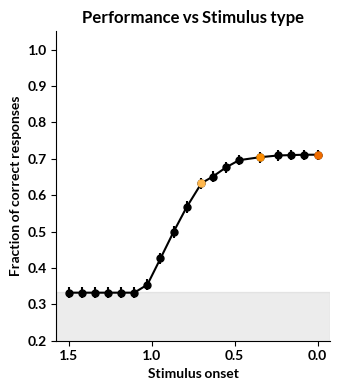

In [412]:

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(3.5, 4))
plt.gca().invert_xaxis()

plt.errorbar(onsets, p[0], yerr=p_err[0], fmt='-o', color='black', capsize=0, markersize=5)
# plt.errorbar(onsets, p[1], yerr=p_err[1], fmt='-s', color='green', capsize=0, label=r'$P(r_C)$')
# plt.errorbar(onsets, p[2], yerr=p_err[2], fmt='-^', color='blue',  capsize=0, label=r'$P(r_R)$')

for tp, col, lab in zip(t_points, stimd_c, labels):
    idx = list(onsets).index(tp)
    plt.plot(tp, p[0, idx], marker='o', markersize=5, 
             color=col, linestyle='None', zorder=5, label=lab)

plt.axhspan(0, 0.333, alpha=0.15, color='gray')
plt.xlabel('Stimulus onset')
plt.ylabel('Fraction of correct responses')
plt.title('Performance vs Stimulus type')
# plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0.2,1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{plot_dir}png/performance_vs_stimulus_type.png', dpi=300)
plt.savefig(f'{plot_dir}svg/performance_vs_stimulus_type.svg')
plt.show()

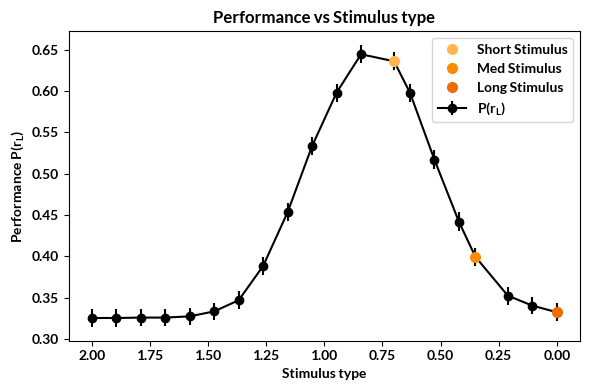

In [89]:
stimd_t =['Short Stimulus', 'Med Stimulus', 'Long Stimulus']

plt.figure(figsize=(6,4))
plt.gca().invert_xaxis()
plt.errorbar(onsets, p[0], yerr=p_err[0],
             fmt='-o', label=r'$P(r_L)$', color='black', capsize=0)

tp_indices = [list(onsets).index(tp) for tp in t_points]

# 2) Extrae P(r_L) (fila 0) en esos índices
p_L_tp = p[0, tp_indices]

# 3) Dibuja los marcadores coloreados
for tp, pl, col, lab in zip(t_points, p_L_tp, stimd_c, stimd_t):
    plt.plot(tp, pl,
             marker='o', markersize=7,
             color=col, linestyle='None', zorder=5, label = lab)

plt.xlabel('Stimulus type')
plt.ylabel('Performance $P(r_L)$')
plt.title('Performance vs Stimulus type')
plt.legend()
plt.tight_layout()
plt.savefig('performance_vs_stimulus_type.png', dpi=300)
plt.show()


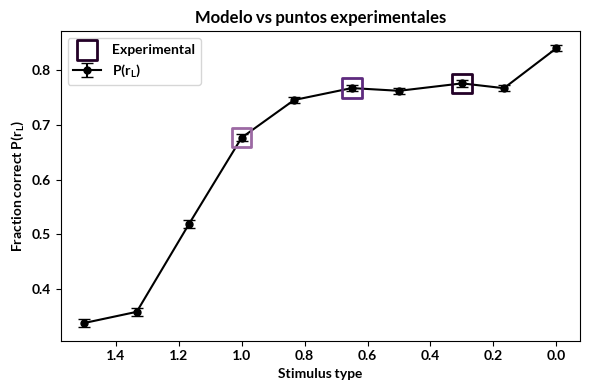

In [106]:
plt.figure(figsize=(6,4))
plt.gca().invert_xaxis()
# 1) Dibuja tu curva de P(r_L) con un marker pequeño y en negro
plt.errorbar(onsets, p[0], yerr=p_err[0],
             fmt='-o', color='black',
             markersize=5, capsize=4, label=r'$P(r_L)$')

# 2) Localiza los índices de tus t_points en el array onsets
tp_indices = [list(onsets).index(tp) for tp in t_points]
p_L_tp     = p[0, tp_indices]

# 3) Superpone un scatter con markers grandes, huecos y borde de color
plt.scatter(t_points, p_L_tp,
            s=200,                 # tamaño de los marcadores
            facecolors='none',     # hueco
            edgecolors=ttypes_c,   # tu paleta
            linewidths=2,          # grosor del borde
            marker='s',            # diamante; cambia a 's','^', etc
            zorder=5,
            label='Experimental')

# 4) Etiquetas y leyenda
plt.xlabel('Stimulus type')
plt.ylabel('Fraction correct P($r_L$)')
plt.title('Modelo vs puntos experimentales')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [176]:
def find_critical(ILv, ICv, IRv):
    x_guess = np.linspace(-10, 10, 5)
    y_guess = np.linspace(-10, 10, 5)
    initial_guesses = np.array(np.meshgrid(x_guess, y_guess)).T.reshape(-1, 2)
    def grad_wrap(pt):
        return np.array(grad_func(pt[0], pt[1], ILv, ICv, IRv), float)
    found = []
    for guess in initial_guesses:
        sol = fsolve(grad_wrap, guess)
        sol = np.round(sol, 4)
        if not any(np.allclose(sol, f) for f in found):
            found.append(sol)
    # clasificar tipo con Hessiana
    crit_pts = []
    for sol in found:
        H_num = np.array(H.subs({X1:sol[0], X2:sol[1], I_L:ILv, I_C:ICv, I_R:IRv}), float)
        eigs = np.linalg.eigvals(H_num)
        if np.all(eigs>0):   ptype='Minimum'
        elif np.all(eigs<0): ptype='Maximum'
        else:                ptype='Saddle'
        crit_pts.append((sol[0], sol[1], ptype))
    return crit_pts



# Videos

## 2D

Ganador: r3


/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3835131714.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  sol = fsolve(grad_wrap, guess)
/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3835131714.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  sol = fsolve(grad_wrap, guess)


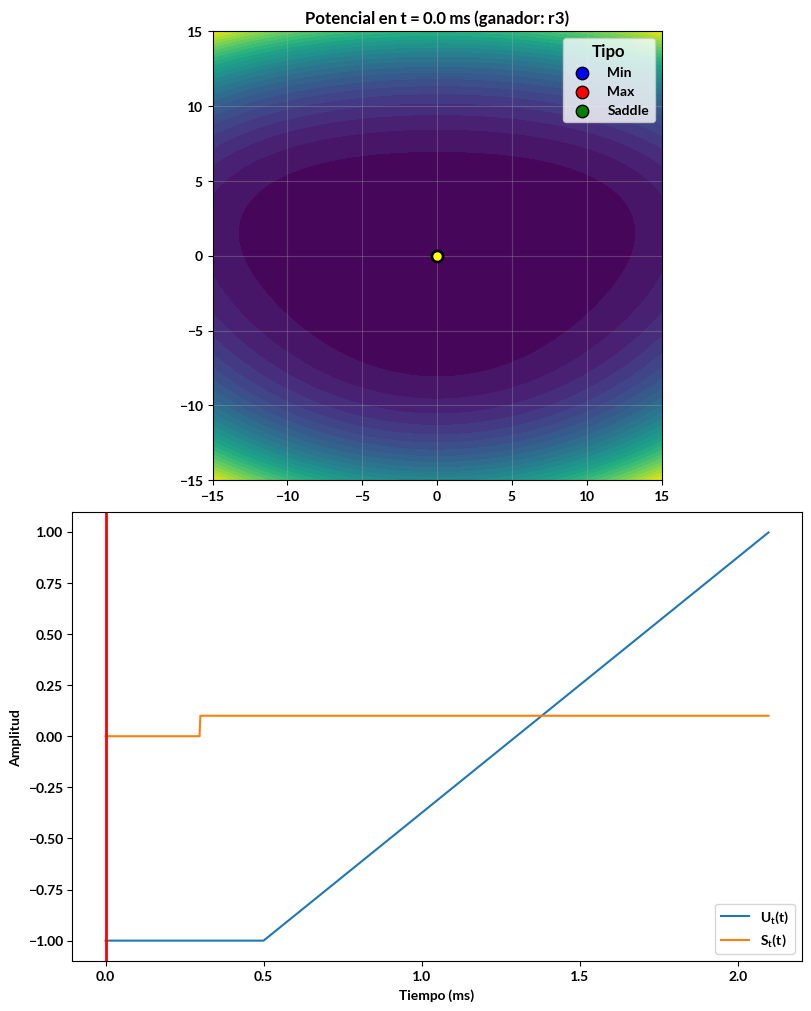

In [337]:
lam_potential = potencial_num
grad_func = lambda x, y, IL, IC, IR: [F1_num(x, y, IL, IC, IR), F2_num(x, y, IL, IC, IR)]


t = np.arange(0, 2.1, tau/40)
x0 = [0.0, 0.0] 
winner = 'r1'
# while winner != 'none':
drift_params = {**values, 'sL': 0.01, 'sC': -0.08, 'sR': -0.05}
lam_potential, _, _, _ = get_expressions(drift_params, type = "numeric", substituted_I = False)
X_path, winner = simulate_path(
    x0,
    S_params = S_params_def,
    U_params = U_params_def,
    drift = drift_factory(values),
    Tmax     = 2.1,   
    dt       = tau / 40, 
    noise_amp= 0.5
)
print(f'Ganador: {winner}')

U_vals = U_t(t, **U_params_def)
S_vals = S_t(t, **S_params_def)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10), constrained_layout=True)

x = np.linspace(-15, 15, 200)
y = np.linspace(-15, 15, 100)
Xg, Yg = np.meshgrid(x, y)



ax2.plot(t, U_vals, label='$U_t(t)$')
ax2.plot(t, S_vals, label='$S_t(t)$')
vline = ax2.axvline(t[0], color='red', lw=2)
ax2.set_xlabel('Tiempo (ms)');  ax2.set_ylabel('Amplitud')
ax2.legend(); 




def update(frame):
    t_ms = t[frame]
    Uv, Sv = U_vals[frame], S_vals[frame]
    ILv, ICv, IRv = Uv+Sv, Uv, Uv

    V = lam_potential(Xg, Yg, ILv, ICv, IRv)
    ax1.clear()
    cf = ax1.contourf(Xg, Yg, V, levels=30, cmap='viridis')
    V = np.clip(V, -50, 50)
    crit_pts = find_critical(ILv, ICv, IRv)
    for x0_, y0_, ptype in crit_pts:
        color = {'Minimum':'blue','Maximum':'red','Saddle':'green'}[ptype]
        ax1.scatter(x0_, y0_, c=color, s=80, edgecolors='k', zorder=3)
    # leyenda de tipos
    for label,color in [('Min','blue'),('Max','red'),('Saddle','green')]:
        ax1.scatter([], [], c=color, label=label, s=80, edgecolors='k')
    ax1.legend(title='Tipo')

    i = min(frame, X_path.shape[0]-1)
    ax1.plot(X_path[:i,0], X_path[:i,1], linewidth=2, color='white', alpha=0.8)
    ax1.scatter(X_path[i,0], X_path[i,1],
                s=50, c='yellow', edgecolors='k', zorder=4)

    ax1.set_title(f'Potencial en t = {t_ms:.1f} ms (ganador: {winner})')
    ax1.set_aspect('equal');  ax1.grid(alpha=0.3)

    vline.set_xdata([t_ms, t_ms])
    return ax1.collections + [vline]


anim = FuncAnimation(fig, update, frames=len(t), interval=50, blit=False)
HTML(anim.to_html5_video())


## 3D

Ganador: r1


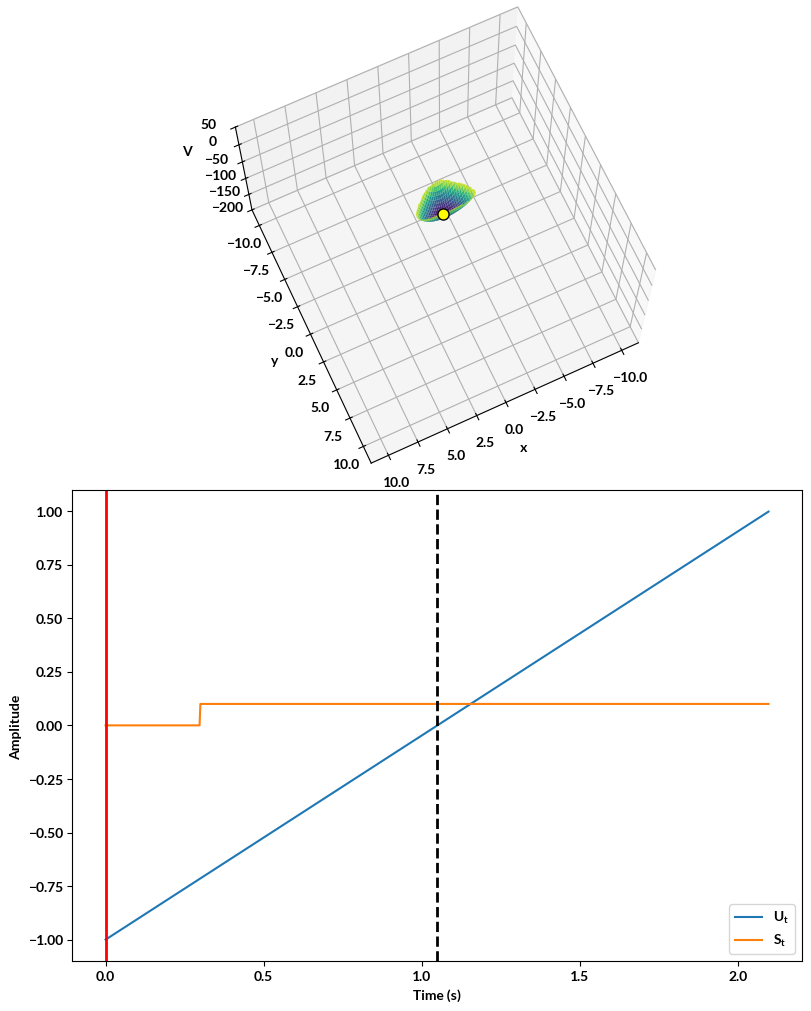

In [338]:

t = np.arange(0, 2.1, tau / 40)
U_base         = {**U_params_def, 'onset':0, 'offset':2.1}
X_path, winner = simulate_path(
    x0,
    S_params = S_params_def,
    U_params = U_base,
    drift = drift_factory(values),
    Tmax     = 2.1,   
    dt       = tau / 40, 
    noise_amp= 0.5
)
print(f'Ganador: {winner}')

U_vals = U_t(t, **U_base)
S_vals = S_t(t, **S_params_def)


xg = np.linspace(-10, 10, 400)
yg = np.linspace(-10, 10, 400)
Xg, Yg = np.meshgrid(xg, yg)

# Figura con dos subplots: uno 3D y otro para estímulos
fig = plt.figure(figsize=(8,10), constrained_layout=True)
ax1 = fig.add_subplot(2,1,1, projection='3d')
ax2 = fig.add_subplot(2,1,2)

# Panel de estímulos
ax2.plot(t, U_vals, label='$U_t$')
ax2.plot(t, S_vals, label='$S_t$')
vline = ax2.axvline(t[0], color='red', lw=2)
ax2.axvline(1.05, color='black', lw=2, linestyle='--')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.legend()

def update(frame):
    t_ms = t[frame]
    Uv, Sv = U_vals[frame], S_vals[frame]
    ILv, ICv, IRv = Uv+Sv, Uv, Uv
    Vg = lam_potential(Xg, Yg, ILv, ICv, IRv)
    mask = (Vg < -200) | (Vg > 50)
    # Vg = np.ma.masked_array(Vg, mask)
    Vg = np.where(mask, np.nan, Vg)
    ax1.clear() 
    # Vg = np.clip(Vg, -50, 50)
    surf = ax1.plot_surface(
        Xg, Yg, Vg,
        rstride=3, cstride=3,
        cmap='viridis',
        edgecolor='none',zorder=1
    )

    # ax1.set_zlim(Vg.min(), Vg.max())

    if X_path.shape[0] > 0:
        z_path = lam_potential(
            X_path[:,0], X_path[:,1], ILv, ICv, IRv
        )
        i = min(frame, len(z_path)-1)
        ax1.plot(
            X_path[:i,0], X_path[:i,1], z_path[:i],
            color='white', linewidth=2, alpha=0.8, zorder=4,
        )
        ax1.plot(
        [X_path[i,0]], [X_path[i,1]], [z_path[i]],
        marker='o', markersize=8, markerfacecolor='yellow', markeredgecolor='k',linestyle='', zorder = 6
        )
    
    # ax1.set_title(f'Potencial 3D en t = {t_ms:.1f} ms (ganador: {winner})')
    ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('V')
    ax1.view_init(elev=70, azim=65)
    vline.set_xdata([t_ms, t_ms])
    ax1.set_zlim(-200, 50)
    return surf, vline


anim3d = FuncAnimation(
    fig, update, frames=len(t),
    interval=10, blit=False
)
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=50)
anim3d.save("anim3d_biased.mp4", writer=writer)
HTML(anim3d.to_html5_video())


# Strengthening factor

In [ ]:
ks      = np.linspace(-0.5, 0.5, 10)
offsets = np.linspace(0, 2.0, 10)

n_k   = len(ks)
n_off = len(offsets)

n_trajs = 1000
p     = np.zeros((n_k, n_off))
p_err = np.zeros_like(p)
X_first = []

for i, k in enumerate(tqdm(ks, desc=f"Procesando ")):
    for j, offset in enumerate(offsets):
        _vals    = {**values, 'sL': k}
        S_params = {**S_params_def, 'offset': offset, 'onset': 0.0}
        _, F1_num, F2_num, _ = get_expressions(_vals, type="numeric", substituted_I=False)

        def drift(X, I_L=IL_val, I_C=IC_val, I_R=IR_val):
            x, y = X
            return np.array([F1_num(x, y, I_L, I_C, I_R), F2_num(x, y, I_L, I_C, I_R)])

        wins = {'r1':0,'r2':0,'r3':0,'none':0}
        for t in range(n_trajs):
            X, w = simulate_path(x0, S_params=S_params, U_params=U_params_def,
                                 noise_amp=0.5, Tmax=2)
            wins[w] += 1
            if t == 0: X_first.append(X.copy())

        p[i,j]     = wins['r1']/n_trajs
        p_err[i,j] = np.sqrt(p[i,j]*(1-p[i,j])/n_trajs)



Procesando :   0%|          | 0/10 [00:00<?, ?it/s]

Procesando :   0%|          | 0/10 [00:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os
import multiprocessing as mp
ctx = mp.get_context('fork')

from concurrent.futures import ProcessPoolExecutor
n_logical = os.cpu_count()  
# Número de CPUs físicos (si necesitas solo los núcleos reales)
try:
    n_physical = multiprocessing.cpu_count()  # en la mayoría de sistemas es igual a os.cpu_count()
except NotImplementedError:
    n_physical = None

print(f"CPUs lógicos disponibles:  {n_logical}")
if n_physical is not None:
    print(f"CPUs físicos disponibles:   {n_physical}")

def simulate_batch(args):
    """
    Simula n_trajs caminos para un mismo (k, offset),
    devuelve (i, j, wins_r1, wins_total).
    """
    i, j, k, offset, values, S_params_def, U_params_def, x0, n_trajs = args

    # construye parámetros
    _vals    = {**values, 'sL': k}
    S_params = {**S_params_def, 'offset': offset, 'onset': 0.0}
    _, F1_num, F2_num, _ = get_expressions(_vals, type="numeric", substituted_I=False)
    def drift(X, I_L=IL_val, I_C=IC_val, I_R=IR_val):
        x, y = X
        return np.array([F1_num(x, y, I_L, I_C, I_R), F2_num(x, y, I_L, I_C, I_R)])

    wins = {'r1':0, 'r2':0, 'r3':0, 'none':0}
    for _ in range(n_trajs):
        X, w = simulate_path(x0, S_params=S_params,
                             U_params=U_params_def,
                             noise_amp=0.5, Tmax=2)
        wins[w] += 1

    # te quedas solo con r1 y total
    return i, j, wins['r1'], n_trajs


# ------------------------------
# Parámetros
ks      = np.linspace(-0.5, 0.5, 10)
offsets = np.linspace(0, 2.0, 10)
n_k, n_off = len(ks), len(offsets)
n_trajs = 1000

p     = np.zeros((n_k, n_off))
p_err = np.zeros_like(p)

# Prepara lista de trabajos
jobs = []
for i, k in enumerate(ks):
    for j, offset in enumerate(offsets):
        jobs.append((i, j, k, offset,
                     values, S_params_def, U_params_def,
                     x0, n_trajs))

# Lanza un pool de procesos (usa todos los cores disponibles).
with ProcessPoolExecutor(max_workers=8,mp_context=ctx) as exe:
    # enviamos todos los jobs
    futures = [exe.submit(simulate_batch, job) for job in jobs]

    # los vamos recogiendo y rellenando p y p_err
    for f in tqdm(as_completed(futures), total=len(futures), desc="Paralelizando"):
        i, j, wins_r1, total = f.result()
        p[i, j]     = wins_r1 / total
        p_err[i, j] = np.sqrt(p[i, j] * (1 - p[i, j]) / total)


CPUs lógicos disponibles:  14
CPUs físicos disponibles:   14


Paralelizando: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


In [309]:
import os, multiprocessing as mp
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from sim_helpers_dynamic import simulate_pair
U_base         = {**U_params_def, 'onset':0, 'offset':2.1}
S_base = {**S_params_def, 'amplitude': 0.15, 'onset': 0.0}
if __name__ == "__main__":
    ks      = np.linspace(-0.1, 0.1, 5)
    # offsets = np.linspace(0, 2.1, 5)
    offsets     = [2.1, 1.05, 0.9,0.8,0 ]
    n_trajs = 1000

    jobs = []
    for i, k in enumerate(ks):
        for j, offset in enumerate(offsets):
            jobs.append((i, j, k, offset,
                         values, S_base, U_base,
                         x0, n_trajs))

    n_workers = max(1, mp.cpu_count() - 6) 
    print(f"Lanzando pool con {n_workers} workers")

    p     = np.zeros((len(ks), len(offsets)))
    p_err = np.zeros_like(p)

    with ProcessPoolExecutor(max_workers=n_workers) as exe:
        futures = [exe.submit(simulate_pair, *job) for job in jobs]
        for f in tqdm(as_completed(futures), total=len(futures)):
            i, j, wins_r1, total = f.result()
            p[i,j]     = wins_r1 / total
            p_err[i,j] = np.sqrt(p[i,j]*(1-p[i,j])/total)


Lanzando pool con 8 workers


100%|██████████| 25/25 [00:45<00:00,  1.82s/it]


/var/folders/gk/r166p6nx2bb5zf2rlwww8fc00000gn/T/ipykernel_69283/3496631873.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


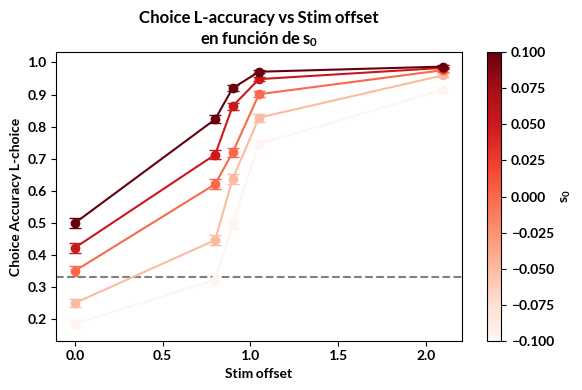

In [310]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6,4))

norm = mpl.colors.Normalize(vmin=ks.min(), vmax=ks.max())
cmap = plt.cm.get_cmap('Reds')

# Dibujamos las curvas
for i, k in enumerate(ks):
    color = cmap(norm(k))
    ax.errorbar(offsets, p[i], yerr=p_err[i],
                fmt='-o', color=color, capsize=4)

# Línea de referencia en 1/3
ax.axhline(1/3, color='gray', linestyle='--')

# Creamos el ScalarMappable y lo asociamos al mismo ax
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)   # <- aquí pasamos ax
cbar.set_label(r'$s_0$')

ax.set_xlabel('Stim offset')
ax.set_ylabel('Choice Accuracy L-choice')
ax.set_title('Choice L-accuracy vs Stim offset\nen función de $s_0$')

fig.tight_layout()
plt.show()


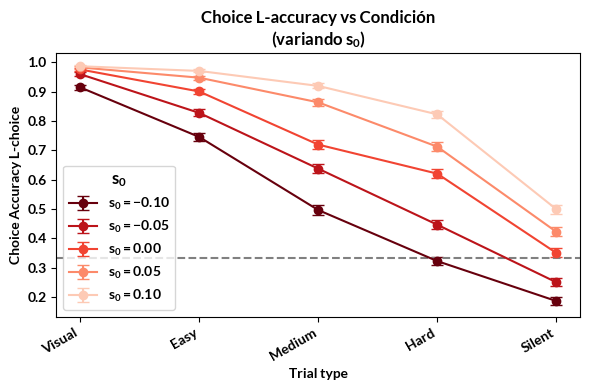

In [311]:
import matplotlib.pyplot as plt
import numpy as np


ks = np.linspace(-0.1, 0.1, 5)
offsets = [2.1, 1.05, 0.9, 0.8, 0]      # no los usamos numéricamente, solo como categorías
labels = ["Visual", "Easy", "Medium", "Hard", "Silent"]

# Creamos posiciones discretas en el eje x
x = np.arange(len(offsets))

# Cogemos una paleta con tantos colores como líneas (=len(ks))
cmap = plt.get_cmap('Reds')
color_vals = np.linspace(1.0, 0.2, len(ks))
colors = cmap(color_vals)

fig, ax = plt.subplots(figsize=(6,4))

for i, k in enumerate(ks):
    ax.errorbar(
        x,               # posiciones enteras 0,1,2,3,4
        p[i],            # tus medias para ese k
        yerr=p_err[i],   # tu error
        fmt='-o',
        color=colors[i],
        capsize=4,
        label=f'$s_0={k:.2f}$'
    )

# línea de referencia
ax.axhline(1/3, color='gray', linestyle='--')

# ticks categóricos
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right')

ax.set_xlabel('Trial type')
ax.set_ylabel('Choice Accuracy L-choice')
ax.set_title('Choice L-accuracy vs Condición\n(variando $s_0$)')

ax.legend(title='$s_0$')

fig.tight_layout()
plt.show()


In [ ]:
def simulate_path_side(x0, side, S_params, U_params, drift_fn,
                       noise_amp=0.5, Tmax=2.1, dt=dt):
    N = int(Tmax / dt)
    X = np.empty((N+1,2));  X[0] = x0
    th1 = th2 = th3 = 0.5

    for i in range(N):
        dW  = np.random.randn(3) * np.sqrt(dt)
        dB1 = (dW[0] - dW[1]) / 2
        dB2 = (dW[0] + dW[1] - 2*dW[2]) / 6
        U   = U_t(i*dt, **U_params)
        S   = S_t(i*dt, **S_params)

        # solo el canal `side` recibe S
        if side=='sL':
            iL, iC, iR = U+S, U,   U
        elif side=='sC':
            iL, iC, iR = U,   U+S, U
        else:
            iL, iC, iR = U,   U,   U+S

        X[i+1] = X[i] + drift_fn(X[i], iL, iC, iR)*dt + noise_amp*np.array([dB1,dB2])

        r1 =  X[i+1,0] +    X[i+1,1]
        r2 = -X[i+1,0] +    X[i+1,1]
        r3 =      -2 *      X[i+1,1]

    if r1>max(r2,r3,th1): return X[:i+2], 'r1'
    if r2>max(r1,r3,th2): return X[:i+2], 'r2'
    if r3>max(r1,r2,th3): return X[:i+2], 'r3'

    return X, 'none'

## Simulating a biased mouse

In [422]:
# Celda: imports
import numpy as np
import matplotlib.pyplot as plt
import sim_helpers
from potencial import get_expressions
parallel_offset_side = sim_helpers.parallel_offset_side
offsets   = [2.1, 1.05, 0.9, 0.8, 0.0]
labels    = ["Visual", "Easy", "Medium", "Hard", "Silent"]
sides     = ['sL','sC','sR']
mapping   = {'r1':'sL','r2':'sC','r3':'sR'}

n_trials  = 1000
x0        = x0  # asegúrate de que x0 esté definido previamente
U_base    = {**U_params_def, 'onset': 0.0, 'offset': 2.1}
S_base    = {**S_params_def, 'amplitude': 0.15}
dt        = 0.1/40
Tmax      = 2.1
noise_amp = 0.5
base_params = {**values, 'sL':0.05, 'sC':-0.02, 'sR':-0.005}
base_params = {**values, 'sL':0.05, 'sC':0, 'sR':0}
_, F1n, F2n, _ = get_expressions(
    base_params,
    type="numeric",
    substituted_I=False
)


def drift_factory(drift_params):
    _, F1n, F2n, _ = get_expressions(
        base_params, type="numeric", substituted_I=False
    )
    return lambda X, iL, iC, iR: np.array([
        F1n(X[0], X[1], iL, iC, iR),
        F2n(X[0], X[1], iL, iC, iR)
    ])

S_base = {**S_params_def, 'amplitude': 0.15, 'onset': 0.0}
update_drift_fn = None
p = parallel_offset_side(
    offsets, sides, mapping,
    S_base, U_params_def,
    base_params, drift_factory,
    x0, n_trajs, Tmax, dt, noise_amp
)



Sweep offsets×sides:   0%|          | 0/15 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [423]:
from sim_helpers_dynamic import simulate_pair_side
base_params = {**values, 'sL':0.01, 'sC':-0.08, 'sR':-0.05}
if __name__ == "__main__":
    # 3.1) Construyo la lista de jobs
    jobs = []
    for i, side in enumerate(sides):
        for j, offset in enumerate(offsets):
            jobs.append((
                i, j, side, offset,
                base_params,
                S_base, U_base,
                x0, n_trajs, Tmax, dt, noise_amp
            ))

    # 3.2) Matrices de output
    p     = np.zeros((len(sides), len(offsets)))
    p_err = np.zeros_like(p)

    # 3.3) Número de workers
    n_workers = max(1, mp.cpu_count() - 5)
    print(f"Lanzando pool con {n_workers} workers")

    # 3.4) Ejecutar en paralelo
    with ProcessPoolExecutor(max_workers=n_workers) as exe:
        futures = [exe.submit(simulate_pair_side, *job) for job in jobs]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Simulando sides×offsets"):
            i, j, wins, total = f.result()
            p[i, j]     = wins / total
            p_err[i, j] = np.sqrt(p[i, j] * (1 - p[i, j]) / total)


Lanzando pool con 9 workers


Simulando sides×offsets: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


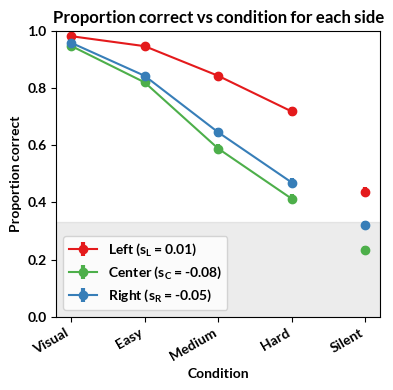

In [424]:
x = np.arange(len(offsets))
silent_idx = labels.index("Silent")
# Índices sin Silent
inds = [j for j in range(len(offsets)) if j != silent_idx]
plt.figure(figsize=(4,4))
colors = ['#e41a1c', '#4daf4a', '#377eb8']
labels     = ["Visual", "Easy", "Medium", "Hard", "Silent"]
labels_side = [f'Left ($s_L$ = {base_params["sL"]})', f'Center ($s_C$ = {base_params["sC"]})', f'Right ($s_R$ = {base_params["sR"]})']
for i, (col, lab) in enumerate(zip(colors, labels_side)):
    plt.errorbar(x[inds],p[i, inds],yerr=p_err[i, inds],fmt='-o',color=col,label=lab,markersize=6,capsize=0,elinewidth=3)
    plt.errorbar(x[silent_idx],p[i, silent_idx],yerr=p_err[i, silent_idx],fmt='o',color=col,capsize=0,elinewidth=3,markersize=6)

plt.xticks(x, labels, rotation=30, ha='right')
plt.axhspan(0, 0.333, alpha=0.15, color='gray')
plt.ylim(0, 1)
plt.xlabel('Condition')
plt.ylabel('Proportion correct')
plt.title('Proportion correct vs condition for each side')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'{plot_dir}png/biased_mouse.png', dpi=300)
plt.savefig(f'{plot_dir}svg/biased_mouse.svg')
plt.show()

# Learning rate

Scanning α: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


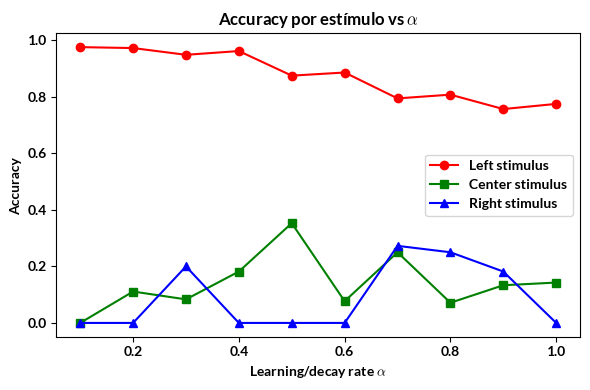

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from potencial import get_expressions

# ————— Parámetros globales —————
n_trials = 100
alphas   = np.linspace(0.1, 1, 10)  # valores de α
p_stim   = [0.8, 0.1, 0.1]      # prob. de estímulo L, C, R
sides    = ['sL','sC','sR']
x0       = x0                  # estado inicial
U_params = U_params_def        # parámetros de U
S_base   = {**S_params_def,    # parámetros base de S
             'offset':0.7, 'onset':0.0}
dt       = 0.1/40              # paso temporal

# ————— Drift factory —————
def drift_factory(params):
    _, F1n, F2n, _ = get_expressions(
        params, type="numeric", substituted_I=False
    )
    return lambda X, iL, iC, iR: np.array([
        F1n(X[0], X[1], iL, iC, iR),
        F2n(X[0], X[1], iL, iC, iR)
    ])

# ————— Simula un trial aplicando S solo al canal “side” —————
def simulate_path_side(x0, side, S_params, U_params, drift_fn,
                       noise_amp=0.5, Tmax=2, dt=dt):
    N = int(Tmax / dt)
    X = np.empty((N+1,2));  X[0] = x0
    th1 = th2 = th3 = 0.5

    for i in range(N):
        dW  = np.random.randn(3) * np.sqrt(dt)
        dB1 = (dW[0] - dW[1]) / 2
        dB2 = (dW[0] + dW[1] - 2*dW[2]) / 6
        U   = U_t(i*dt, **U_params)
        S   = S_t(i*dt, **S_params)

        # solo el canal `side` recibe S
        if side=='sL':
            iL, iC, iR = U+S, U,   U
        elif side=='sC':
            iL, iC, iR = U,   U+S, U
        else:
            iL, iC, iR = U,   U,   U+S

        X[i+1] = X[i] + drift_fn(X[i], iL, iC, iR)*dt + noise_amp*np.array([dB1,dB2])

        r1 =  X[i+1,0] +    X[i+1,1]
        r2 = -X[i+1,0] +    X[i+1,1]
        r3 =      -2 *      X[i+1,1]

        if r1>max(r2,r3,th1): return X[:i+2], 'r1'
        if r2>max(r1,r3,th2): return X[:i+2], 'r2'
        if r3>max(r1,r2,th3): return X[:i+2], 'r3'

    return X, 'none'

# ————— Simula n_trials para un α dado —————
def simulate_for_alpha(alpha, gamma = 0.001):
    # inicializa s_i en 0
    drift_params = {**values, 'sL':0.0, 'sC':0.0, 'sR':0.0}
    # contadores
    stim_counts   = {s:0 for s in sides}
    correct_counts= {s:0 for s in sides}

    for _ in range(n_trials):
        # 1) elige estímulo
        stim = np.random.choice(sides, p=p_stim)
        stim_counts[stim] += 1

        # 2) crea drift_fn
        drift_fn = drift_factory(drift_params)

        # 3) simula trial
        _, winner = simulate_path_side(
            x0, stim, S_base, U_params, drift_fn
        )

        # 4) evalúa acierto
        mapping = {'r1':'sL','r2':'sC','r3':'sR'}
        if mapping.get(winner) == stim:
            correct_counts[stim] += 1
        # 5) actualiza s para **todos** los lados:
        for s in sides:
            drift_params[s] = drift_params[s] * alpha
            if s == stim:
                drift_params[s] += gamma

    # 6) compute accuracy por lado
    accuracy = {s: (correct_counts[s]/stim_counts[s] if stim_counts[s]>0 else np.nan)
                for s in sides}
    return alpha, accuracy

# ————— Paralelizar sobre α con tqdm —————
n_workers = min(len(alphas), mp.cpu_count()-5)
results = []
with ProcessPoolExecutor(max_workers=n_workers,
                         mp_context=mp.get_context('fork')) as exe:
    for res in tqdm(exe.map(simulate_for_alpha, alphas),
                    total=len(alphas),
                    desc="Scanning α"):
        results.append(res)

# ————— Organizar resultados y plot —————
results_sorted = sorted(results, key=lambda x: x[0])
alphas_sorted  = [a for a,_ in results_sorted]
acc_L = [acc['sL'] for _,acc in results_sorted]
acc_C = [acc['sC'] for _,acc in results_sorted]
acc_R = [acc['sR'] for _,acc in results_sorted]

plt.figure(figsize=(6,4))
plt.plot(alphas_sorted, acc_L, '-o', label='Left stimulus',   color='red')
plt.plot(alphas_sorted, acc_C, '-s', label='Center stimulus', color='green')
plt.plot(alphas_sorted, acc_R, '-^', label='Right stimulus',  color='blue')

plt.xlabel(r'Learning/decay rate $\alpha$')
plt.ylabel('Accuracy')
plt.title('Accuracy por estímulo vs ' + r'$\alpha$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from potencial import get_expressions
# from sim_helpers import simulate_path_side  # la versión que aplica S al canal

# ————— Parámetros globales —————
n_trials   = 100
n_sessions = 20
alpha      = 0.01                # α fijo para este ejemplo
gamma     = 0.001               # incremento de drift
p_stim     = [1/3, 1/3, 1/3]      # P(Left,Center,Right)
sides      = ['sL','sC','sR']
x0         = x0                   # tu estado inicial
U_params   = U_params_def
S_base   = {**S_params_def,    # parámetros base de S
             'offset':0.7, 'onset':0.0}
dt         = 0.1/40
mapping = {'r1':'sL','r2':'sC','r3':'sR'}


def drift_factory(params):
    _, F1n, F2n, _ = get_expressions(
        params, type="numeric", substituted_I=False
    )
    return lambda X, iL, iC, iR: np.array([
        F1n(X[0], X[1], iL, iC, iR),
        F2n(X[0], X[1], iL, iC, iR)
    ])


def simulate_session(args):
    session_idx, alpha, gamma = args
    # Aseguramos reproducibilidad por sesión
    rng = np.random.RandomState(session_idx)

    # parámetros sensoriales iniciales
    drift_params = {**values, 'sL':0.2, 'sC':0.0, 'sR':0.0}
    session_data = []

    mapping = {'r1':'sL','r2':'sC','r3':'sR'}

    for _ in range(n_trials):
        stim = rng.choice(sides, p=p_stim)
        drift_fn = drift_factory(drift_params)
        _, winner = simulate_path_side(
            x0, stim, S_base, U_params, drift_fn,
            noise_amp=0.5, Tmax=2, dt=dt
        )
        session_data.append((stim, winner))

        for s in sides:
            drift_params[s] = drift_params[s] * alpha
            if s == stim:
                drift_params[s] += gamma

    return session_data

# ————— Paralelizamos las sesiones —————
n_workers = min(n_sessions, mp.cpu_count() - 4)
with ProcessPoolExecutor(max_workers=n_workers,
                         mp_context=mp.get_context('fork')) as exe:
    jobs = [(i, alpha, gamma) for i in range(n_sessions)]
    sessions_data = list(tqdm(exe.map(simulate_session, jobs),
                              total=n_sessions,
                              desc="Simulating sessions"))

acc_sessions = np.zeros((n_sessions, len(sides)))
for i, sess in enumerate(sessions_data):
    counts  = {s:0 for s in sides}
    correct = {s:0 for s in sides}
    for stim, winner in sess:
        counts[stim] += 1
        if mapping.get(winner) == stim:
            correct[stim] += 1
    for j, s in enumerate(sides):
        acc_sessions[i,j] = (correct[s] / counts[s]) if counts[s]>0 else np.nan

plt.figure(figsize=(8,4))
x = np.arange(1, n_sessions+1)
colors = ['red','green','blue']
labels = ['Left','Center','Right']

for j, (col, lab) in enumerate(zip(colors, labels)):
    plt.plot(x, acc_sessions[:,j], '-o', color=col, label=lab)

plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title(f'Accuracy por lado (α={alpha:.2f})')
plt.xticks(x)
plt.ylim(0,1)
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


width = 0.2
plt.figure(figsize=(10,4))
for j, (col, lab) in enumerate(zip(colors, labels)):
    plt.bar(x + (j-1)*width, acc_sessions[:,j], width,
            color=col, label=lab)

plt.xlabel('Session')
plt.ylabel('Accuracy')s
plt.title(f'Accuracy por lado y por sesión (α={alpha:.2f})')
plt.xticks(x)
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Simulating sessions:  50%|█████     | 10/20 [00:50<00:50,  5.05s/it]


KeyboardInterrupt: 

In [344]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from potencial import get_expressions
# ————— Parámetros globales —————
n_trials   = 100
n_sessions = 25
alpha      = (50-1)/50                 # parámetro de aprendizaje/decay
gamma     = 0.001                 # incremento de drift
p_stim     = [3/4, 1/8, 1/8]       # P(Left,Center,Right)
sides      = ['sL','sC','sR']
mapping    = {'r1':'sL','r2':'sC','r3':'sR'}
x0         = x0                    # tu estado inicial
U_params   = U_params_def          # parámetros de U
S_base     = {**S_params_def,      # parámetros de S
               'offset':0.9,
               'onset' :0.0}
dt         = 0.1/40                # paso temporal

# ————— Drift factory —————
def drift_factory(params):
    _, F1n, F2n, _ = get_expressions(
        params, type="numeric", substituted_I=False
    )
    return lambda X, iL, iC, iR: np.array([
        F1n(X[0], X[1], iL, iC, iR),
        F2n(X[0], X[1], iL, iC, iR)
    ])

# ————— Simula un trial con S solo en el canal `side` —————
def simulate_path_side(x0, side, S_params, U_params, drift_fn,
                       noise_amp=0.5, Tmax=2, dt=dt):
    N = int(Tmax / dt)
    X = np.empty((N+1,2)); X[0]=x0
    th1 = th2 = th3 = 0.5
    for i in range(N):
        dW = np.random.randn(3)*np.sqrt(dt)
        dB1, dB2 = (dW[0]-dW[1])/2, (dW[0]+dW[1]-2*dW[2])/6
        U = U_t(i*dt, **U_params)
        S = S_t(i*dt, **S_params)
        # solo el canal estimulado recibe S
        if side=='sL':    iL,iC,iR = U+S, U,   U
        elif side=='sC':  iL,iC,iR = U,   U+S, U
        else:             iL,iC,iR = U,   U,   U+S
        X[i+1] = X[i] + drift_fn(X[i], iL,iC,iR)*dt + noise_amp*np.array([dB1,dB2])
        r1 =  X[i+1,0] +    X[i+1,1]
        r2 = -X[i+1,0] +    X[i+1,1]
        r3 =      -2 *      X[i+1,1]
        if r1>max(r2,r3,th1): return X[:i+2],'r1'
        if r2>max(r1,r3,th2): return X[:i+2],'r2'
        if r3>max(r1,r2,th3): return X[:i+2],'r3'
    return X, 'none'

drift_params = {**values, 'sL':0.0, 'sC':0.0, 'sR':0.0}

acc_sessions = np.zeros((n_sessions, len(sides)))
total_trials = n_sessions * n_trials
s_hist = np.zeros((total_trials, 3))  # columnas: sL, sC, sR
trial_idx = 0
for sess_idx in tqdm(range(n_sessions), desc="Sessions"):
    correct_counts = {s:0 for s in sides}
    stim_counts    = {s:0 for s in sides}

    for _ in range(n_trials):
        stim = np.random.choice(sides, p=p_stim)
        stim_counts[stim] += 1

        drift_fn = drift_factory(drift_params)
        _, winner = simulate_path_side(x0, stim, S_base, U_params, drift_fn)

        if mapping[winner] == stim:
            correct_counts[stim] += 1

        for s in sides:
            drift_params[s] = drift_params[s] * alpha
            if s == stim:
                drift_params[s] += gamma
        s_hist[trial_idx, :] = [drift_params['sL'],
                                    drift_params['sC'],
                                    drift_params['sR']]
        trial_idx += 1

    # 6) compute session accuracy
    for j, s in enumerate(sides):
        acc_sessions[sess_idx,j] = (correct_counts[s]/stim_counts[s]
                                    if stim_counts[s] > 0 else np.nan)

# ————— Visualización —————
sessions = np.arange(1, n_sessions+1)
colors   = ['red','green','blue']
labels   = ['Left','Center','Right']



Sessions: 100%|██████████| 25/25 [10:04<00:00, 24.18s/it]


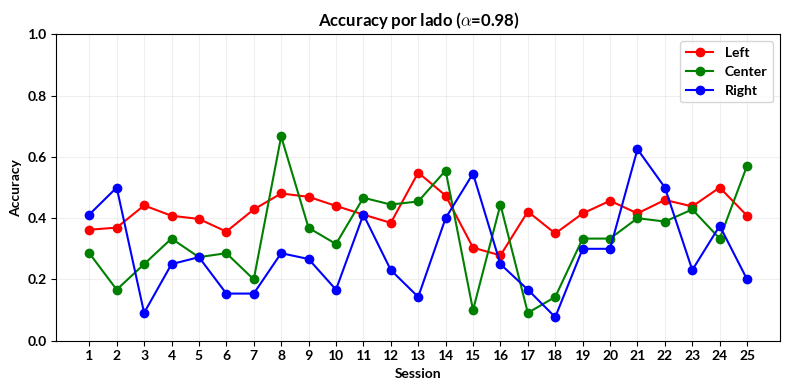

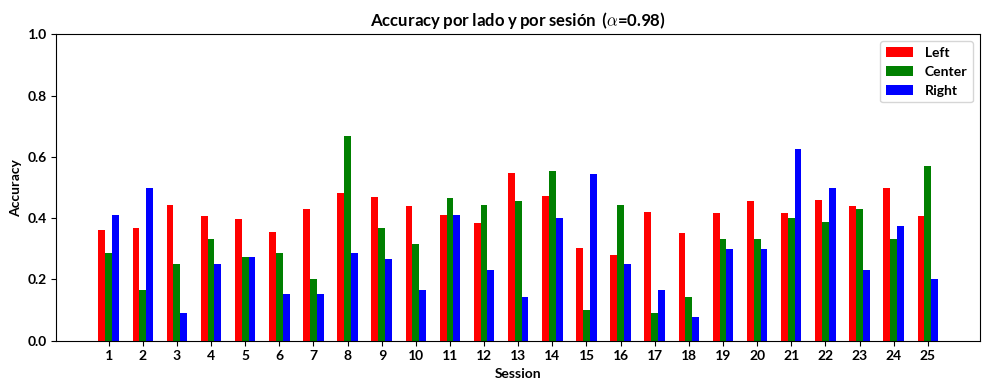

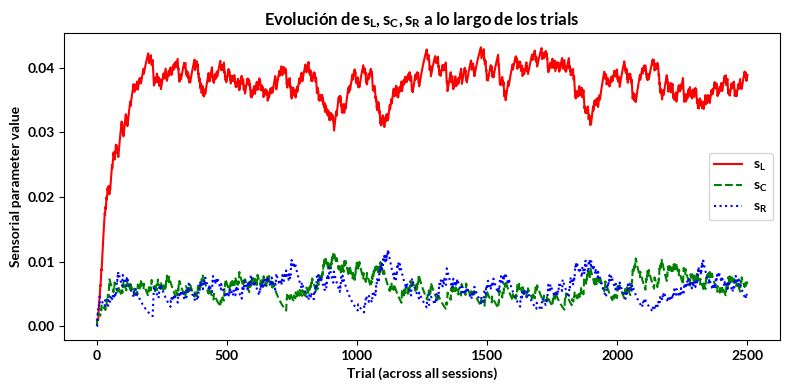

In [345]:
# curvas lineales
plt.figure(figsize=(8,4))
for j,(col,lab) in enumerate(zip(colors, labels)):
    plt.plot(sessions, acc_sessions[:,j], '-o', color=col, label=lab)
plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title(f'Accuracy por lado ('+r'$\alpha$'+f'={alpha:.2f})')
plt.ylim(0,1)
plt.xticks(sessions)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# barras agrupadas
width=0.2
plt.figure(figsize=(10,4))
for j,(col,lab) in enumerate(zip(colors,labels)):
    plt.bar(sessions + (j-1)*width,
            acc_sessions[:,j], width,
            color=col, label=lab)
plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title(f'Accuracy por lado y por sesión  ('+r'$\alpha$'+f'={alpha:.2f})')
plt.ylim(0,1)
plt.xticks(sessions)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{plot_dir}png/accuracy_sessions_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.png', dpi=300)
plt.savefig(f'{plot_dir}svg/accuracy_sessions_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.svg')
plt.show()


plt.figure(figsize=(8,4))
trials = np.arange(1, total_trials+1)
plt.plot(trials, s_hist[:,0], '-',  color='red',   label=r'$s_L$')
plt.plot(trials, s_hist[:,1], '--', color='green', label=r'$s_C$')
plt.plot(trials, s_hist[:,2], ':',  color='blue',  label=r'$s_R$')
plt.xlabel('Trial (across all sessions)')
plt.ylabel('Sensorial parameter value')
plt.title('Evolución de $s_L, s_C, s_R$ a lo largo de los trials')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

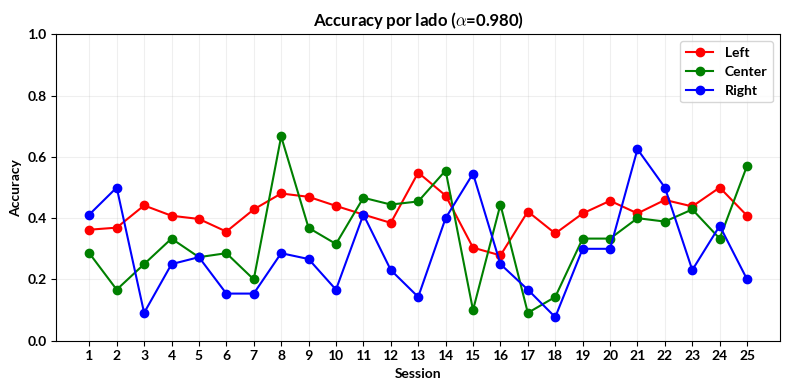

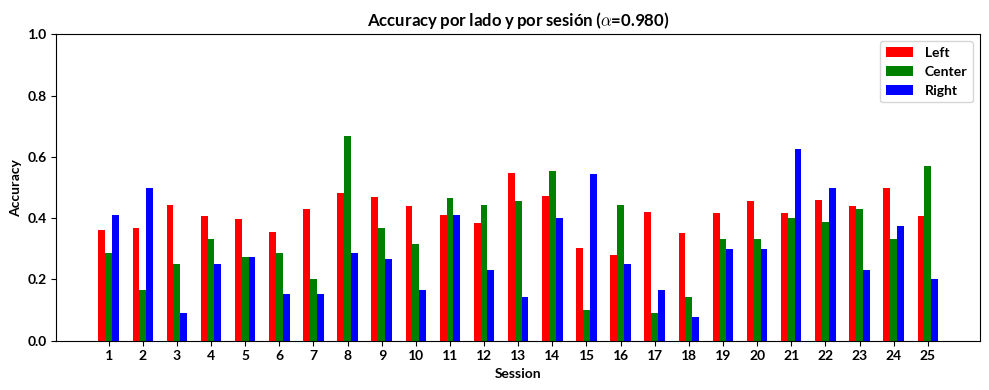

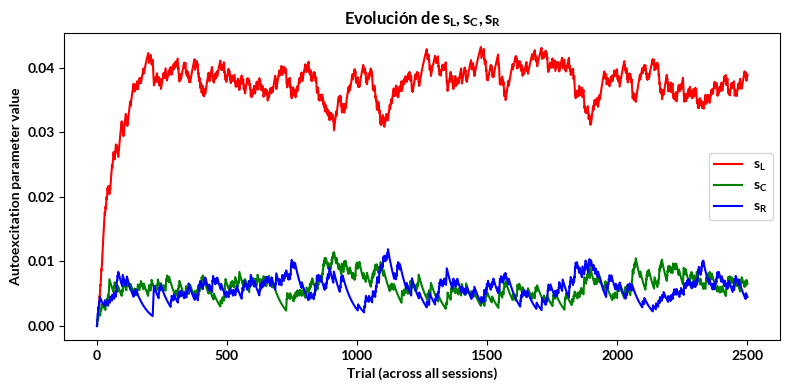

In [350]:

# curvas lineales
plt.figure(figsize=(8,4))
for j,(col,lab) in enumerate(zip(colors, labels)):
    plt.plot(sessions, acc_sessions[:,j], '-o', color=col, label=lab)
plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title(f'Accuracy por lado ('+ r'$\alpha$'+f'={alpha:.3f})')
plt.ylim(0,1)
plt.xticks(sessions)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}png/accuracy_sessions_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.png', dpi=300)
plt.show()

# barras agrupadas
width=0.2
plt.figure(figsize=(10,4))
for j,(col,lab) in enumerate(zip(colors,labels)):
    plt.bar(sessions + (j-1)*width,
            acc_sessions[:,j], width,
            color=col, label=lab)
plt.xlabel('Session')
plt.ylabel('Accuracy')
plt.title('Accuracy por lado y por sesión ('+ r'$\alpha$'+f'={alpha:.3f})')
plt.ylim(0,1)
plt.xticks(sessions)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'{plot_dir}png/accuracy_sessions_hist_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.png', dpi=300)
plt.savefig(f'{plot_dir}svg/accuracy_sessions_hist_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.svg')
plt.show()


plt.figure(figsize=(8,4))
trials = np.arange(1, total_trials+1)
plt.plot(trials, s_hist[:,0], '-',  color='red',   label=r'$s_L$')
plt.plot(trials, s_hist[:,1], '-', color='green', label=r'$s_C$')
plt.plot(trials, s_hist[:,2], '-',  color='blue',  label=r'$s_R$')
plt.xlabel('Trial (across all sessions)')
plt.ylabel('Autoexcitation parameter value')
plt.title('Evolución de $s_L, s_C, s_R$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f'{plot_dir}png/autoexcitation_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.png', dpi=300)
plt.savefig(f'{plot_dir}svg/autoexcitation_{p_stim[0]:.2f}_{p_stim[1]:.2f}_{p_stim[2]:.2f}_a_{alpha}.svg')
plt.show()

Running 10k trials: 100%|██████████| 10000/10000 [01:48<00:00, 91.82it/s]

Outcome proportions: {'r1': 0.33, 'r2': 0.3331, 'r3': 0.3369, 'none': 0.0}


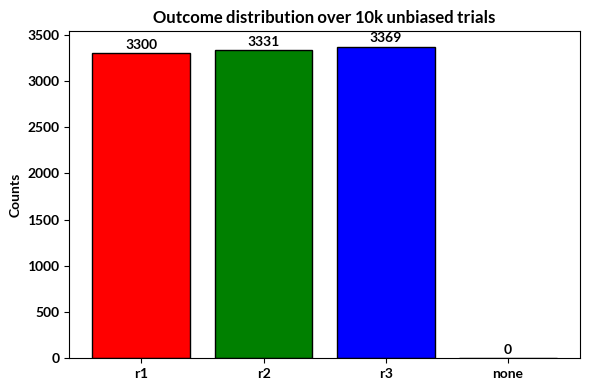

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from multiprocessing.dummy import Pool as ThreadPool
from tqdm import tqdm
from potencial import get_expressions

# ————— Parámetros fijos —————
n_trials   = 10_000
x0         = x0            # tu estado inicial
U_params   = U_params_def  # parámetros de U
S_params   = {**S_params_def, 'onset':0.0, 'offset':0.0, 'amplitude':0.0}
dt         = 0.1/40
Tmax       = 2.1
noise_amp  = 0.5

# ————— Drift fijo —————
# Cogemos los valores simbólicos iniciales sin sL,sC,sR
base_params = {**values, 'sL':0.0, 'sC':0.0, 'sR':0.0}
_, F1n, F2n, _ = get_expressions(base_params, type="numeric", substituted_I=False)
def drift_fn(X, iL, iC, iR):
    x, y = X
    return np.array([F1n(x, y, iL, iC, iR),
                     F2n(x, y, iL, iC, iR)])

# ————— Función para un solo trial —————
def run_trial(_):
    X, winner = simulate_path(
        x0,
        S_params = S_params,
        U_params = U_params,
        drift    = drift_fn,
        noise_amp= noise_amp,
        Tmax     = Tmax,
        dt       = dt
    )
    return winner
# ————— Paralelización con ThreadPool —————
counts = {'r1':0, 'r2':0, 'r3':0, 'none':0}
n_workers = min(10, np.maximum(1, mp.cpu_count()-1))

with ThreadPool(n_workers) as pool:
    for w in tqdm(pool.imap(run_trial, range(n_trials)),
                  total=n_trials,
                  desc="Running 10k trials"):
        counts[w] += 1

# ————— Resultados —————
props = {k: counts[k]/n_trials for k in counts}
print("Outcome proportions:", props)

# ————— Gráfico —————
labels = ['r1','r2','r3','none']
vals   = [counts[k] for k in labels]
colors = ['red','green','blue','gray']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals, color=colors, edgecolor='k')
plt.ylabel('Counts')
plt.title('Outcome distribution over 10k unbiased trials')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, h+50, f'{h}', ha='center')
plt.tight_layout()
plt.show()
